<a href="https://colab.research.google.com/github/SATYAVARDHAN04/BRAIN_TUMOR_CLASSIFICATION/blob/main/finalimplementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BRAIN TUMOR CLASSIFICATION USING MRI IMAGES

### **Medical Context**
The detection and characterization of brain tumors is a major public health challenge. MRI (Magnetic Resonance Imaging) is the primary diagnostic tool for detecting and characterizing brain tumors. The three tumor types in our dataset have distinct characteristics:

- **Glioma**: Primary brain tumor developing from glial cells; often aggressive and requires prompt treatment.
- **Meningioma**: Usually benign tumor arising from the meninges; more common in women.
- **Pituitary tumor**: Tumor of the pituitary gland, usually benign but can affect hormone levels.

### **Project Objectives**
**Main objective:**
Develop an automatic classification system that performs:

- **Binary detection:** Identify presence or absence of a tumor.
- **Multi-class classification:** If a tumor is detected, determine its type among the three categories.

**Secondary objectives:**

- Assist radiologists in early diagnosis
- Reduce MRI analysis time
- Provide a second opinion for validation
- Improve diagnostic accessibility in under-resourced areas

### **Success criteria:**

- **Overall accuracy:** > 90% on the test set
- **Sensitivity (Recall):** > 95% for tumor detection (minimize false negatives)
- **Specificity:** > 90% to avoid false positives
- Balanced confusion matrix across classes

## DATA UNDERSTANDING

Before any transformation, an exploratory data analysis (EDA) is necessary to validate image quality.

**Distribution analysis:** The numerical disparity between the "Tumor" and "No_tumor" classes may bias the model toward detection errors (e.g., higher false negatives).

**Visual variance analysis:** Images in the "no_tumor" class show variable dimensions, whereas tumor images are often 512x512. A uniform resizing step is required to ensure consistent input tensors.

**Integrity check:** Visual inspection using pixel histograms helps verify that brightness and contrast are consistent across folders, preventing the model from learning acquisition artifacts instead of pathology.

In [1]:
pip install numpy pandas matplotlib seaborn opencv-python scikit-learn tensorflow kagglehub

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

In [3]:
import kagglehub

# Download latest version
path1 = kagglehub.dataset_download("sartajbhuvaji/brain-tumor-classification-mri")
path2 = kagglehub.dataset_download("sofienehermi/brain-tumor-balanced")

print("Path to dataset files:", path1)
print("Path to dataset files:", path2)

Using Colab cache for faster access to the 'brain-tumor-classification-mri' dataset.
Using Colab cache for faster access to the 'brain-tumor-balanced' dataset.
Path to dataset files: /kaggle/input/brain-tumor-classification-mri
Path to dataset files: /kaggle/input/brain-tumor-balanced


In [4]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


## DATA SET EXPLORATION

In [5]:
BASE_PATH = path1
dataset_info = {
    'Training': defaultdict(int),
    'Testing': defaultdict(int)
}

image_dimensions = {
    'Training': defaultdict(list),
    'Testing': defaultdict(list)
}

# Parcourir Training et Testing
for split in ['Training', 'Testing']:
    split_path = os.path.join(BASE_PATH, split)

    if not os.path.exists(split_path):
        continue

    print(f"\n{split}")
    print("-" * 70)

    # Parcourir les classes
    for class_name in os.listdir(split_path):
        class_path = os.path.join(split_path, class_name)

        if os.path.isdir(class_path):
            # Compter les images
            images = [f for f in os.listdir(class_path)
                     if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            count = len(images)
            dataset_info[split][class_name] = count

            print(f"  ├─ {class_name:25s}: {count:4d} images")

            # Échantillonner quelques images pour analyser les dimensions
            sample_size = min(50, count)
            for img_name in images[:sample_size]:
                img_path = os.path.join(class_path, img_name)
                try:
                    img = Image.open(img_path)
                    image_dimensions[split][class_name].append(img.size)
                except:
                    pass

    total = sum(dataset_info[split].values())
    print(f"  └─ {'TOTAL':25s}: {total:4d} images")


Training
----------------------------------------------------------------------
  ├─ no_tumor                 :  395 images
  ├─ pituitary_tumor          :  827 images
  ├─ meningioma_tumor         :  822 images
  ├─ glioma_tumor             :  826 images
  └─ TOTAL                    : 2870 images

Testing
----------------------------------------------------------------------
  ├─ no_tumor                 :  105 images
  ├─ pituitary_tumor          :   74 images
  ├─ meningioma_tumor         :  115 images
  ├─ glioma_tumor             :  100 images
  └─ TOTAL                    :  394 images


## IMAGE DIMESNION ANALYSIS

In [6]:
for split in ['Training', 'Testing']:
    print(f"\n {split}:")
    print("-" * 70)

    for class_name, dims in image_dimensions[split].items():
        if dims:
            widths = [d[0] for d in dims]
            heights = [d[1] for d in dims]

            unique_dims = set(dims)

            print(f"\n  {class_name}:")
            print(f"    Unique Dimensions: {len(unique_dims)}")

            if len(unique_dims) == 1:
                print(f"    Uniform Size: {dims[0][0]}x{dims[0][1]}")
            else:
                print(f"    Width    - Min: {min(widths):4d}, Max: {max(widths):4d}, Average: {np.mean(widths):.1f}")
                print(f"    Height   - Min: {min(heights):4d}, Max: {max(heights):4d}, Average: {np.mean(heights):.1f}")
                print(f"    Most Frequent Dimensions: {max(set(dims), key=dims.count)}")


 Training:
----------------------------------------------------------------------

  no_tumor:
    Unique Dimensions: 35
    Width    - Min:  201, Max: 1280, Average: 370.3
    Height   - Min:  211, Max:  851, Average: 362.7
    Most Frequent Dimensions: (236, 236)

  pituitary_tumor:
    Unique Dimensions: 2
    Width    - Min:  474, Max:  512, Average: 511.2
    Height   - Min:  474, Max:  512, Average: 511.2
    Most Frequent Dimensions: (512, 512)

  meningioma_tumor:
    Unique Dimensions: 8
    Width    - Min:  206, Max:  825, Average: 484.3
    Height   - Min:  225, Max:  993, Average: 490.8
    Most Frequent Dimensions: (512, 512)

  glioma_tumor:
    Unique Dimensions: 1
    Uniform Size: 512x512

 Testing:
----------------------------------------------------------------------

  no_tumor:
    Unique Dimensions: 30
    Width    - Min:  205, Max:  321, Average: 237.7
    Height   - Min:  213, Max:  351, Average: 249.0
    Most Frequent Dimensions: (236, 236)

  pituitary_tumor

## CLASS IMBALANCE ANALYSIS

In [7]:
for split in ['Training', 'Testing']:
    print(f"\n {split}:")
    print("-" * 70)

    counts = dataset_info[split]
    if not counts:
        continue

    total = sum(counts.values())

    # Create a DataFrame for analysis
    df = pd.DataFrame({
        'Class': list(counts.keys()),
        'Count': list(counts.values()),
        'Percentage': [v/total*100 for v in counts.values()]
    })

    df = df.sort_values('Count', ascending=False)
    print(df.to_string(index=False))

    # Imbalance ratio
    max_count = max(counts.values())
    min_count = min(counts.values())
    imbalance_ratio = max_count / min_count if min_count > 0 else 0

    print(f"\n  Imbalance Ratio: {imbalance_ratio:.2f}:1")
    print(f"  (Majority Class / Minority Class)")


 Training:
----------------------------------------------------------------------
           Class  Count  Percentage
 pituitary_tumor    827   28.815331
    glioma_tumor    826   28.780488
meningioma_tumor    822   28.641115
        no_tumor    395   13.763066

  Imbalance Ratio: 2.09:1
  (Majority Class / Minority Class)

 Testing:
----------------------------------------------------------------------
           Class  Count  Percentage
meningioma_tumor    115   29.187817
        no_tumor    105   26.649746
    glioma_tumor    100   25.380711
 pituitary_tumor     74   18.781726

  Imbalance Ratio: 1.55:1
  (Majority Class / Minority Class)


## VISUALIZATION OF SAMPLES

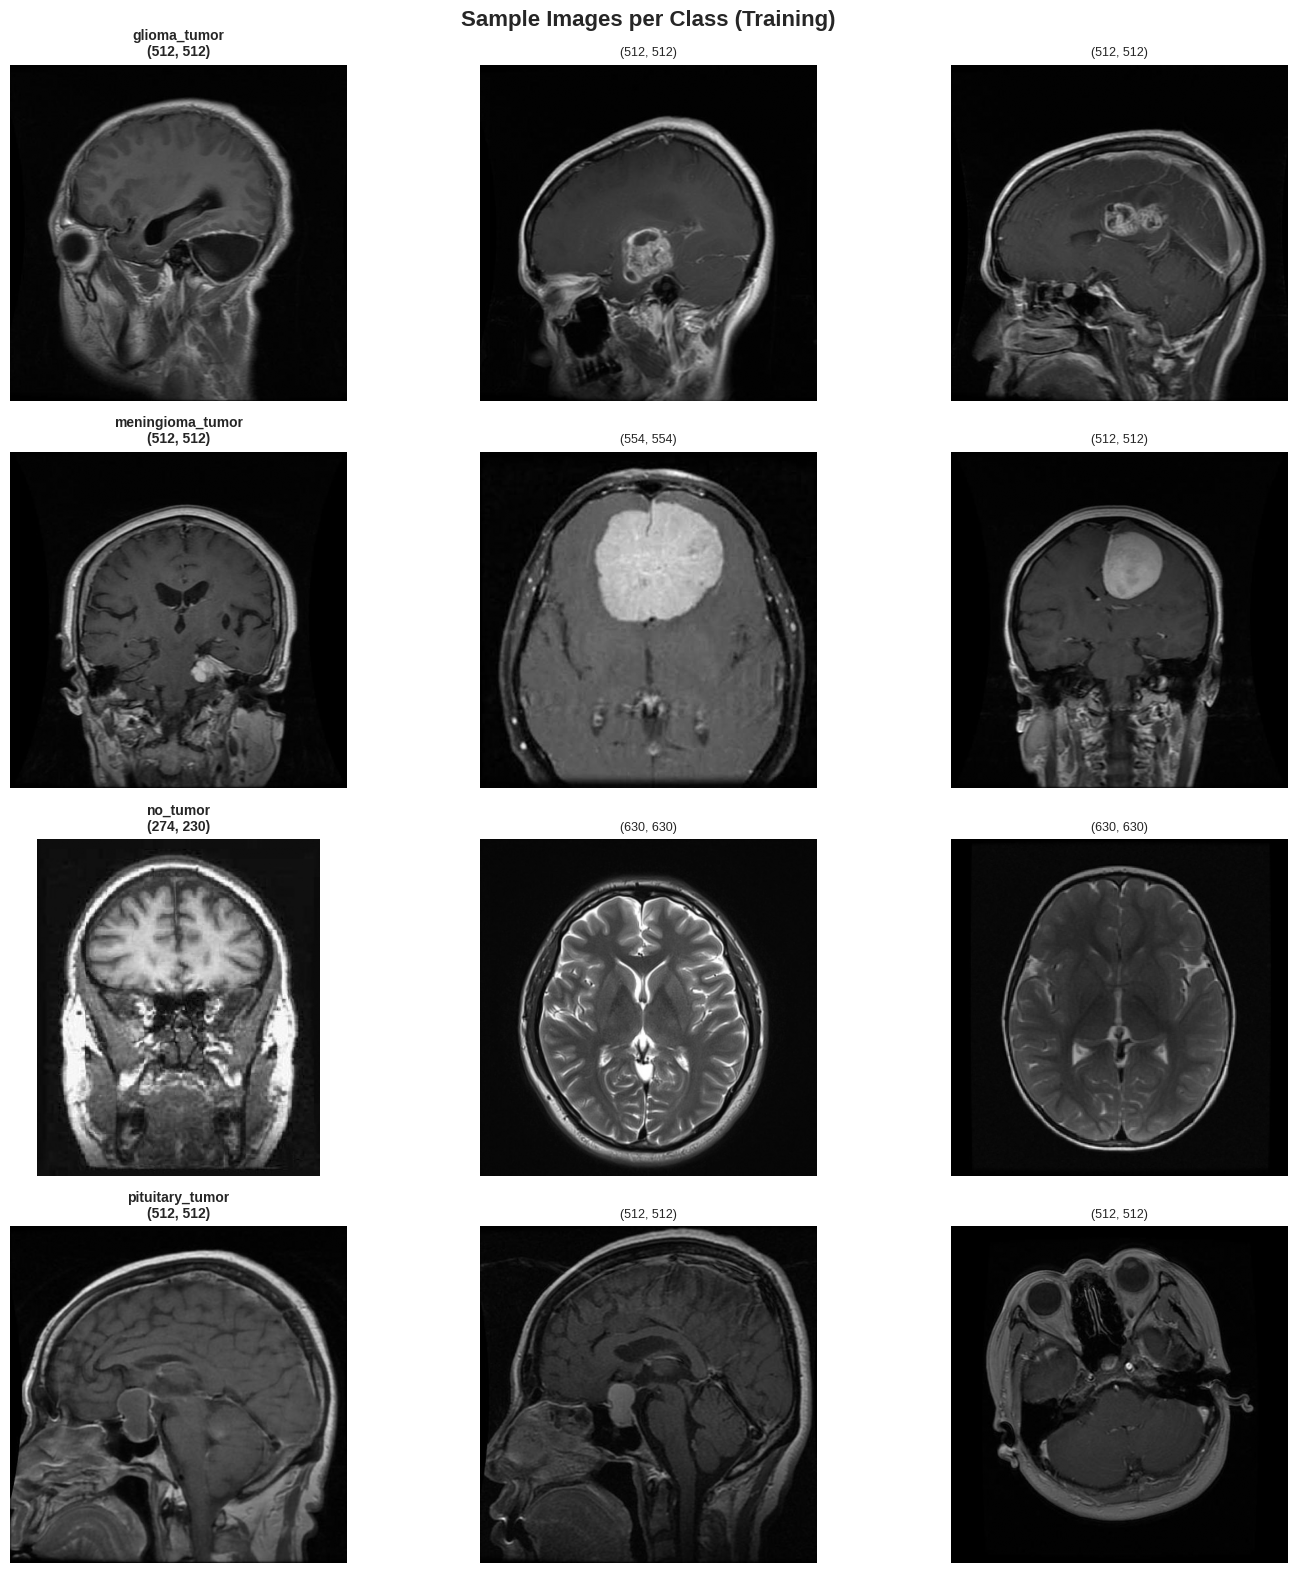

In [8]:
split = 'Training'
split_path = os.path.join(BASE_PATH, split)
classes = sorted([d for d in os.listdir(split_path)
                 if os.path.isdir(os.path.join(split_path, d))])

samples_per_class = 3

fig, axes = plt.subplots(len(classes), samples_per_class,
                         figsize=(15, 4*len(classes)))
fig.suptitle('Sample Images per Class (Training)',
             fontsize=16, fontweight='bold')

for i, class_name in enumerate(classes):
    class_path = os.path.join(split_path, class_name)
    images = [f for f in os.listdir(class_path)
             if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    # Sélectionner des échantillons aléatoires
    samples = np.random.choice(images,
                              min(samples_per_class, len(images)),
                              replace=False)

    for j, img_name in enumerate(samples):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        ax = axes[i, j] if len(classes) > 1 else axes[j]
        ax.imshow(img, cmap='gray')
        ax.axis('off')

        if j == 0:
            ax.set_title(f"{class_name}\n{img.shape}",
                       fontsize=10, fontweight='bold')
        else:
            ax.set_title(f"{img.shape}", fontsize=9)

plt.tight_layout()
plt.show()

## PIXEL STATISTICAL ANALYSIS

In [9]:
split = 'Training'
split_path = os.path.join(BASE_PATH, split)
classes = sorted([d for d in os.listdir(split_path)
                 if os.path.isdir(os.path.join(split_path, d))])

sample_size = 100
stats = {}

for class_name in classes:
    class_path = os.path.join(split_path, class_name)
    images = [f for f in os.listdir(class_path)
             if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    # Échantillonner
    samples = np.random.choice(images,
                              min(sample_size, len(images)),
                              replace=False)

    pixel_values = []

    for img_name in samples:
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        pixel_values.extend(img.flatten())

    pixel_values = np.array(pixel_values)

    stats[class_name] = {
        'mean': np.mean(pixel_values),
        'std': np.std(pixel_values),
        'min': np.min(pixel_values),
        'max': np.max(pixel_values),
        'median': np.median(pixel_values)
    }

# Afficher les résultats
print(f"\n Statistics (on {sample_size} images per class):")
print("-" * 70)

df_stats = pd.DataFrame(stats).T
df_stats = df_stats.round(2)
print(df_stats)


 Statistics (on 100 images per class):
----------------------------------------------------------------------
                   mean    std  min    max  median
glioma_tumor      36.49  41.63  0.0  255.0    13.0
meningioma_tumor  44.14  50.40  0.0  255.0    18.0
no_tumor          57.93  58.72  0.0  255.0    43.0
pituitary_tumor   53.76  45.64  0.0  255.0    55.0


## PIXEL INTESNSITY ANALYSIS


 Generating pixel intensity histograms...


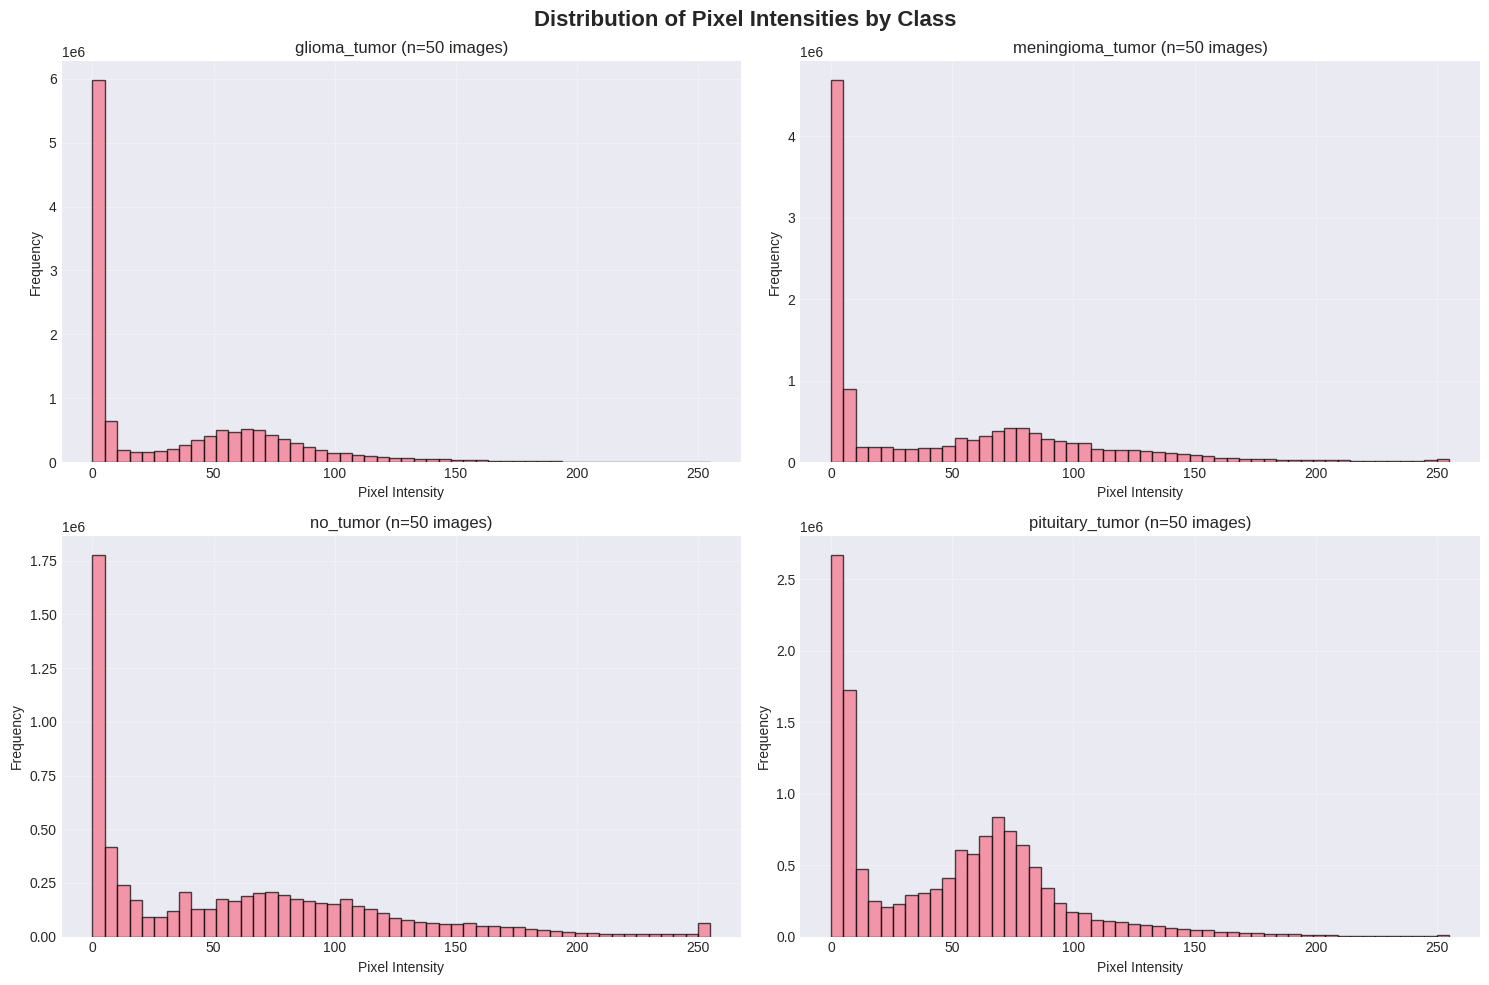

In [10]:
print("\n Generating pixel intensity histograms...")

split = 'Training'
split_path = os.path.join(BASE_PATH, split)
classes = sorted([d for d in os.listdir(split_path)
                 if os.path.isdir(os.path.join(split_path, d))])

sample_size_hist = 50

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Distribution of Pixel Intensities by Class',
             fontsize=16, fontweight='bold')
axes = axes.flatten()

for idx, class_name in enumerate(classes):
    class_path = os.path.join(split_path, class_name)
    images = [f for f in os.listdir(class_path)
             if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    samples = np.random.choice(images,
                              min(sample_size_hist, len(images)),
                              replace=False)

    pixel_values = []
    for img_name in samples:
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        pixel_values.extend(img.flatten())

    axes[idx].hist(pixel_values, bins=50, alpha=0.7, edgecolor='black')
    axes[idx].set_title(f'{class_name} (n={len(samples)} images)')
    axes[idx].set_xlabel('Pixel Intensity')
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## CLASS DISTRIBUTION CHARTS


 Generating distribution plots...


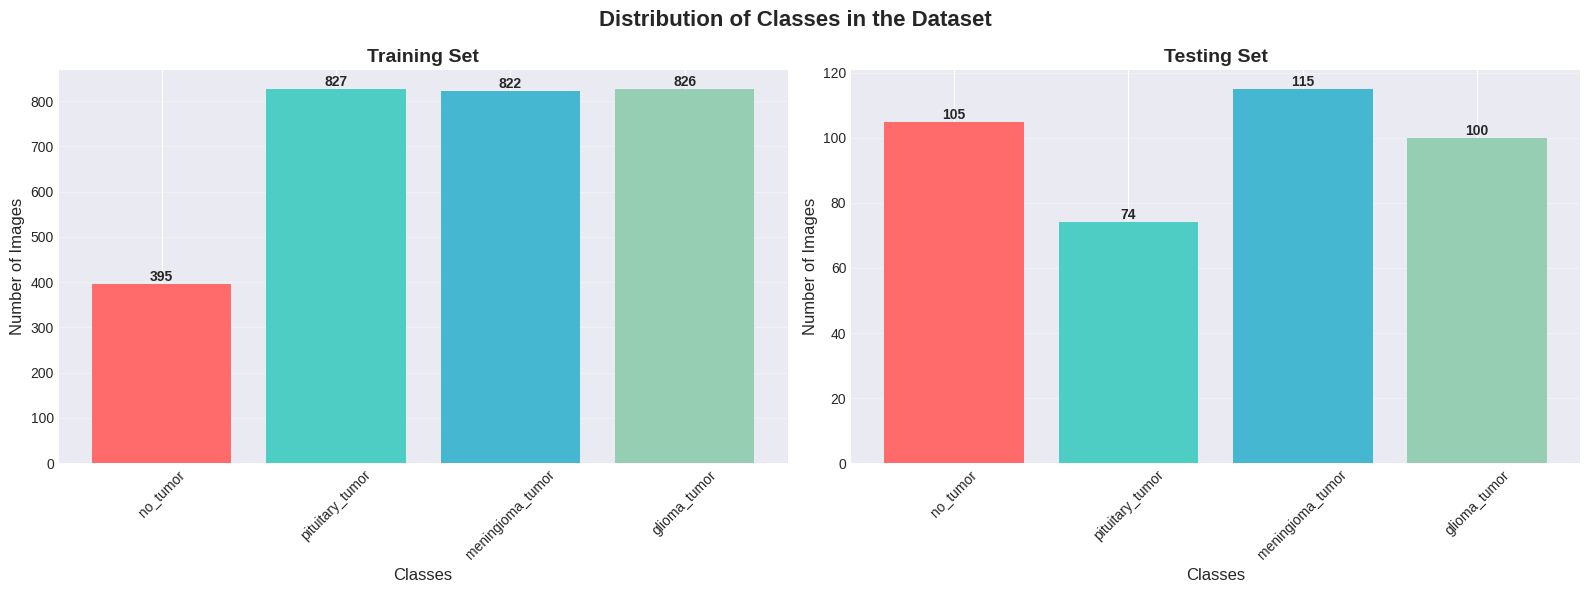

In [11]:
print("\n Generating distribution plots...")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Distribution of Classes in the Dataset',
             fontsize=16, fontweight='bold')

for idx, split in enumerate(['Training', 'Testing']):
    counts = dataset_info[split]
    if not counts:
        continue

    classes_list = list(counts.keys())
    values = list(counts.values())

    # Bar chart
    bars = axes[idx].bar(classes_list, values,
                        color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
    axes[idx].set_title(f'{split} Set', fontsize=14, fontweight='bold')
    axes[idx].set_ylabel('Number of Images', fontsize=12)
    axes[idx].set_xlabel('Classes', fontsize=12)
    axes[idx].tick_params(axis='x', rotation=45)

    # Add values on the bars
    for bar in bars:
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                      f'{int(height)}',
                      ha='center', va='bottom', fontweight='bold')

    axes[idx].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## **EXPLORATORY PHASE SUMMARY**

**Key findings:**
- Dataset structured into Training/Testing
- 4 classes: glioma_tumor, meningioma_tumor, pituitary_tumor, no_tumor
- Significant imbalance: 'no_tumor' underrepresented
- Variable dimensions in Testing; Training images are generally 512x512 except in the NO_TUMOR class

**Class distribution (Training)**

Total: 2,870 images
- Glioma: 826 (28.8%)
- Meningioma: 822 (28.6%)
- Pituitary: 827 (28.8%)
- No Tumor: 395 (13.8%) -> Underrepresented

**Class distribution (Testing)**

Total: 389 images
Relatively balanced across classes

**Technical characteristics**
- Training format: standardized 512×512 grayscale images
- Testing format: JPG images of variable dimensions -> requires preprocessing
- Channels: Grayscale images (1 channel)

**Critical observation:** There is a significant class imbalance: pathological classes are overrepresented compared to the healthy class in the training set

## **DATA PREPARATION**

This is the pivotal step of our project. Here we aim to balance the Tumor and no_tumor classes. We will use K-means clustering to determine 200 representative clusters for each tumor type so that the total of the "tumor" class becomes 600 images (200+200+200). For augmenting the no_tumor class we will use a diffusion model to generate synthetic images.

In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import shutil
from tqdm import tqdm
import zipfile
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')


In [13]:
BASE_PATH = '/kaggle/input/brain-tumor-classification-mri'
OUTPUT_BASE = '/kaggle/working/kmeans_output'

# Create structure
folders = [
    'selected_images/glioma',
    'selected_images/meningioma',
    'selected_images/pituitary',
    'original_no_tumor',
    'metrics'
]

print("\n Creating structure...")
for folder in folders:
    os.makedirs(os.path.join(OUTPUT_BASE, folder), exist_ok=True)
print(f" {len(folders)} folders created")


 Creating structure...
 5 folders created


## **K-MEANS TO SELECT 200 IMAGES PER TUMOR TYPE**

**Methodology:**

For each tumor type:

1. Extract descriptors (features) from images (e.g., flattening, PCA, or CNN embeddings).
2. Apply K-means with K = 200.
3. Select one image per cluster (the image closest to the centroid).

Thus, for each tumor type we obtain 200 representative images:

- 200 Glioma
- 200 Meningioma
- 200 Pituitary

These images are then merged to form a single 'tumor' class for the binary classification task.

**Advantages:**

- Selection guided by the data structure.
- Reduced redundancy bias.
- Better coverage of the feature space.

#### **STEP - 1** IMAGE SELECTION WITH K-MEANS

In [14]:
tumor_classes = ['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor']
target_per_class = 200
image_size = (128, 128)

print(f"\nObjective: {target_per_class} images per class")
print(f"Metrics: Inertia, Silhouette, Davies-Bouldin")

kmeans_metrics = {}

for tumor_class in tumor_classes:
    print(f"\n{'='*70}")
    print(f"Processing: {tumor_class}")
    print(f"{'='*70}")

    class_path = os.path.join(BASE_PATH, 'Training', tumor_class)
    all_images = [f for f in os.listdir(class_path)
                  if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    print(f"   Total images: {len(all_images)}")

    # Feature extraction
    features_list = []
    valid_images = []

    for img_name in tqdm(all_images, desc="  Extracting Features"):
        try:
            img = cv2.imread(os.path.join(class_path, img_name), cv2.IMREAD_GRAYSCALE)
            img_resized = cv2.resize(img, image_size)
            features = (img_resized.astype('float32') / 255.0).flatten()
            features_list.append(features)
            valid_images.append(img_name)
        except:
            continue

    features_array = np.array(features_list)
    print(f"   Features shape: {features_array.shape}")

    # K-Means
    print(f"   Running K-Means (K={target_per_class})...")
    kmeans = KMeans(n_clusters=target_per_class, random_state=42, n_init=10, max_iter=300)
    cluster_labels = kmeans.fit_predict(features_array)

    # Metrics
    inertia = kmeans.inertia_
    silhouette = silhouette_score(features_array, cluster_labels)
    davies_bouldin = davies_bouldin_score(features_array, cluster_labels)

    print(f"\n   METRICS:")
    print(f"  • Inertia: {inertia:.2f}")
    print(f"  • Silhouette: {silhouette:.4f}")
    print(f"  • Davies-Bouldin: {davies_bouldin:.4f}")

    kmeans_metrics[tumor_class] = {
        'inertia': inertia,
        'silhouette': silhouette,
        'davies_bouldin': davies_bouldin
    }

    # Select representative images
    print(f"\n   Selecting representative images...")
    selected_indices = []

    for cluster_id in range(target_per_class):
        cluster_indices = np.where(cluster_labels == cluster_id)[0]
        if len(cluster_indices) == 0:
            continue
        centroid = kmeans.cluster_centers_[cluster_id]
        distances = np.linalg.norm(features_array[cluster_indices] - centroid, axis=1)
        selected_indices.append(cluster_indices[np.argmin(distances)])

    selected_names = [valid_images[idx] for idx in selected_indices]
    print(f"   {len(selected_names)} images selected")

    # Copy images
    class_short = tumor_class.replace('_tumor', '')
    dest_path = os.path.join(OUTPUT_BASE, 'selected_images', class_short)

    for img_name in tqdm(selected_names, desc="  Copying Images"):
        shutil.copy2(os.path.join(class_path, img_name),
                    os.path.join(dest_path, img_name))


Objective: 200 images per class
Metrics: Inertia, Silhouette, Davies-Bouldin

Processing: glioma_tumor
   Total images: 826


  Extracting Features: 100%|██████████| 826/826 [00:05<00:00, 145.89it/s]


   Features shape: (826, 16384)
   Running K-Means (K=200)...

   METRICS:
  • Inertia: 63080.79
  • Silhouette: 0.1156
  • Davies-Bouldin: 1.5487

   Selecting representative images...
   200 images selected


  Copying Images: 100%|██████████| 200/200 [00:00<00:00, 630.28it/s]



Processing: meningioma_tumor
   Total images: 822


  Extracting Features: 100%|██████████| 822/822 [00:05<00:00, 145.05it/s]


   Features shape: (822, 16384)
   Running K-Means (K=200)...

   METRICS:
  • Inertia: 92893.45
  • Silhouette: 0.1238
  • Davies-Bouldin: 1.3608

   Selecting representative images...
   200 images selected


  Copying Images: 100%|██████████| 200/200 [00:00<00:00, 619.04it/s]



Processing: pituitary_tumor
   Total images: 827


  Extracting Features: 100%|██████████| 827/827 [00:06<00:00, 133.81it/s]


   Features shape: (827, 16384)
   Running K-Means (K=200)...

   METRICS:
  • Inertia: 52604.88
  • Silhouette: 0.2767
  • Davies-Bouldin: 1.1990

   Selecting representative images...
   200 images selected


  Copying Images: 100%|██████████| 200/200 [00:00<00:00, 670.96it/s]


### **STEP - 2** K-MEANS EVALUATION METRICS

In [15]:
print(f"{'Classe':<15} {'Inertie':<15} {'Silhouette':<15} {'Davies-Bouldin':<15}")
print("-"*70)
for tumor_class, metrics in kmeans_metrics.items():
    class_name = tumor_class.replace('_tumor', '').upper()
    print(f"{class_name:<15} {metrics['inertia']:<15.2f} {metrics['silhouette']:<15.4f} {metrics['davies_bouldin']:<15.4f}")


Classe          Inertie         Silhouette      Davies-Bouldin 
----------------------------------------------------------------------
GLIOMA          63080.79        0.1156          1.5487         
MENINGIOMA      92893.45        0.1238          1.3608         
PITUITARY       52604.88        0.2767          1.1990         


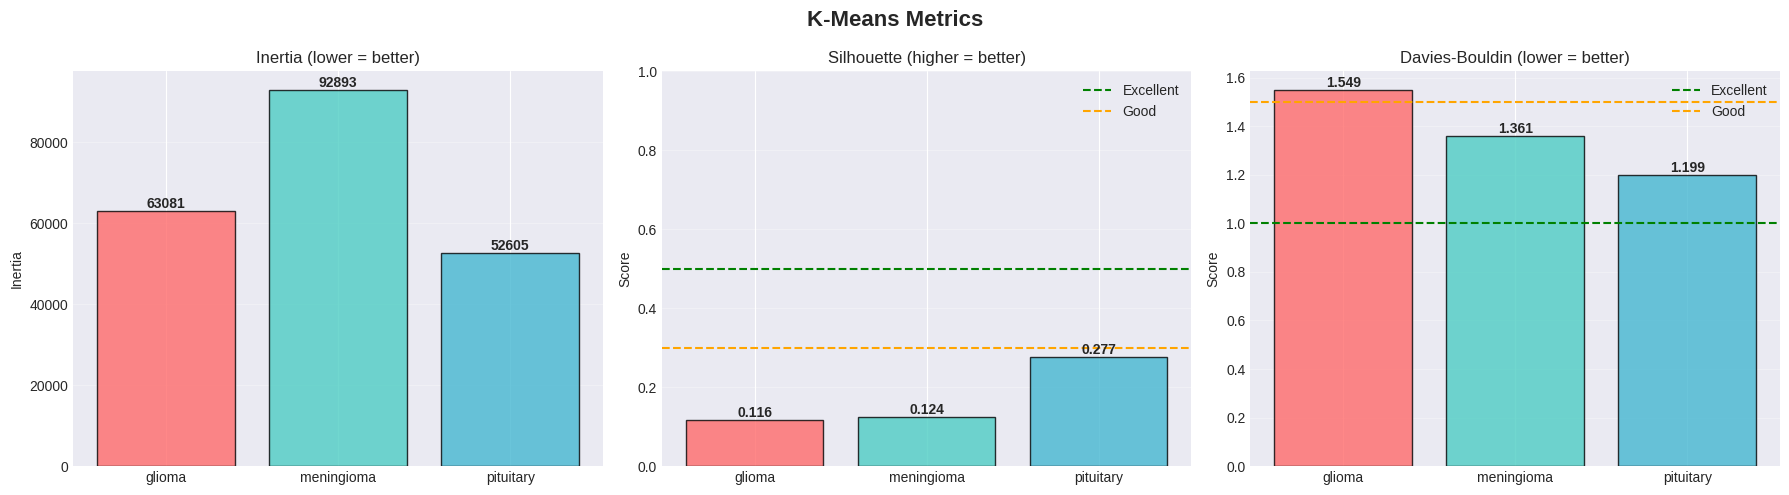

In [16]:
# Visualisation
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('K-Means Metrics', fontsize=16, fontweight='bold')

classes_short = [k.replace('_tumor', '') for k in kmeans_metrics.keys()]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

# Inertia
inertia_vals = [kmeans_metrics[k]['inertia'] for k in kmeans_metrics.keys()]
axes[0].bar(classes_short, inertia_vals, color=colors, alpha=0.8, edgecolor='black')
axes[0].set_title('Inertia (lower = better)')
axes[0].set_ylabel('Inertia')
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(inertia_vals):
    axes[0].text(i, v, f'{v:.0f}', ha='center', va='bottom', fontweight='bold')

# Silhouette
sil_vals = [kmeans_metrics[k]['silhouette'] for k in kmeans_metrics.keys()]
axes[1].bar(classes_short, sil_vals, color=colors, alpha=0.8, edgecolor='black')
axes[1].axhline(y=0.5, color='green', linestyle='--', label='Excellent')
axes[1].axhline(y=0.3, color='orange', linestyle='--', label='Good')
axes[1].set_title('Silhouette (higher = better)')
axes[1].set_ylabel('Score')
axes[1].set_ylim(0, 1)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(sil_vals):
    axes[1].text(i, v, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# Davies-Bouldin
db_vals = [kmeans_metrics[k]['davies_bouldin'] for k in kmeans_metrics.keys()]
axes[2].bar(classes_short, db_vals, color=colors, alpha=0.8, edgecolor='black')
axes[2].axhline(y=1.0, color='green', linestyle='--', label='Excellent')
axes[2].axhline(y=1.5, color='orange', linestyle='--', label='Good')
axes[2].set_title('Davies-Bouldin (lower = better)')
axes[2].set_ylabel('Score')
axes[2].legend()
axes[2].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(db_vals):
    axes[2].text(i, v, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_BASE, 'metrics', 'kmeans_metrics.png'), dpi=150, bbox_inches='tight')
plt.show()

### **STEP - 3** COPY ORIGINAL NO_TUMOR IMAGES

In [17]:
no_tumor_path = os.path.join(BASE_PATH, 'Training', 'no_tumor')
no_tumor_images = [f for f in os.listdir(no_tumor_path)
                   if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

print(f"Total no_tumor: {len(no_tumor_images)}")

dest_no_tumor = os.path.join(OUTPUT_BASE, 'original_no_tumor')

for img_name in tqdm(no_tumor_images, desc="Copying"):
    shutil.copy2(os.path.join(no_tumor_path, img_name),
                os.path.join(dest_no_tumor, img_name))

print(f" {len(no_tumor_images)} images copied")

Total no_tumor: 395


Copying: 100%|██████████| 395/395 [00:01<00:00, 249.60it/s]

 395 images copied


In [18]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
zip_filename = f'kmeans_results_{timestamp}.zip'
zip_path = os.path.join('/kaggle/working', zip_filename)

print(f"\n Compressing files...")

with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(OUTPUT_BASE):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, OUTPUT_BASE)
            zipf.write(file_path, arcname)

zip_size = os.path.getsize(zip_path) / (1024 * 1024)
print(f"  ZIP created!")
print(f"   Name: {zip_filename}")
print(f"   Size: {zip_size:.2f} MB")
print(f"   Location: /kaggle/working/{zip_filename}")

print("\n" + "="*70)
print("DOWNLOAD INSTRUCTIONS")
print("="*70)
print("1. Click on 'Output' in the right panel")
print(f"2. Find: {zip_filename}")
print("3. Click on '...' then 'Download'")
print("4. KEEP THIS ZIP LOCALLY!")
print("="*70)

print("\n  PART 1 COMPLETED - DOWNLOAD THE ZIP NOW!")
print("   Then, run PART 2 (Diffusion Model)")
print("="*70 + "\n")


 Compressing files...
  ZIP created!
   Name: kmeans_results_20260202_125141.zip
   Size: 26.85 MB
   Location: /kaggle/working/kmeans_results_20260202_125141.zip

DOWNLOAD INSTRUCTIONS
1. Click on 'Output' in the right panel
2. Find: kmeans_results_20260202_125141.zip
3. Click on '...' then 'Download'
4. KEEP THIS ZIP LOCALLY!

  PART 1 COMPLETED - DOWNLOAD THE ZIP NOW!
   Then, run PART 2 (Diffusion Model)



## SYNTHETIC IMAGE GENERATION

The tumor class initially contains about 400 images, which is insufficient for robust training of a deep model. Artificial augmentation is therefore necessary.

Classical methods (rotation, flip, noise) are limited and produce little semantic diversity. Diffusion models (**DDPM – Denoising Diffusion Probabilistic Models**) offer a powerful alternative.

**Principle of diffusion models:**

DDPMs rely on:

- A progressive noising process applied to images.

- A learned reverse process, implemented by a neural network, to reconstruct images.

- Once trained, the model can generate new realistic images that are statistically close to the original MRI images.

Why choose DDPMs:

- Ability to generate realistic medical images.

- Preservation of anatomical structures.

- Reduced overfitting through dataset diversification.

In this work, DDPMs are used to generate 200 synthetic images, bringing the tumor class to 600 images.

In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import zipfile
from datetime import datetime
import shutil
import warnings
warnings.filterwarnings('ignore')

In [20]:
BASE_PATH = '/kaggle/input/brain-tumor-classification-mri'
OUTPUT_BASE = '/kaggle/working/ddpm_output'

print(f"Dataset original: {BASE_PATH}")
print(f"Output: {OUTPUT_BASE}")

# Create structure
folders = [
    'original_no_tumor',
    'generated_images',
    'model',
    'samples'
]

print("\n Creating structure...")
for folder in folders:
    os.makedirs(os.path.join(OUTPUT_BASE, folder), exist_ok=True)
print(f" {len(folders)} folders created")

Dataset original: /kaggle/input/brain-tumor-classification-mri
Output: /kaggle/working/ddpm_output

 Creating structure...
 4 folders created


In [21]:
no_tumor_path = os.path.join(BASE_PATH, 'Training', 'no_tumor')
no_tumor_images = [f for f in os.listdir(no_tumor_path)
                   if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

print(f"Total no_tumor: {len(no_tumor_images)}")

temp_no_tumor = os.path.join(OUTPUT_BASE, 'original_no_tumor')

for img_name in tqdm(no_tumor_images, desc="Copie"):
    shutil.copy2(os.path.join(no_tumor_path, img_name),
                os.path.join(temp_no_tumor, img_name))

print(f" {len(no_tumor_images)} images copied")

Total no_tumor: 395


Copie: 100%|██████████| 395/395 [00:00<00:00, 1517.93it/s]

 395 images copied


In [22]:
import subprocess
import sys

print(" Installation diffusers, torch...")
try:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q",
                          "diffusers", "transformers", "accelerate", "torch", "torchvision"])
    print("Dependencies installed!")
except Exception as e:
    print(f" Error: {e}")

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from diffusers import DDPMScheduler, UNet2DModel, DDPMPipeline
from diffusers.optimization import get_cosine_schedule_with_warmup
from tqdm.auto import tqdm as tqdm_auto
from PIL import Image as PILImage

# Initialize the noise scheduler
noise_scheduler = DDPMScheduler()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n Device: {device}")
if device.type == "cuda":
    print(f"   GPU: {torch.cuda.get_device_name(0)}")

 Installation diffusers, torch...
Dependencies installed!


Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.



 Device: cuda
   GPU: Tesla T4


##PREPARATION OF THE NO_TUMOR DATASET

In [23]:
class BrainMRIDataset(Dataset):
    def __init__(self, image_dir, image_size=128):
        self.image_dir = image_dir
        self.image_files = [f for f in os.listdir(image_dir)
                           if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = PILImage.open(img_path)
        return self.transform(image)

image_size = 128
dataset = BrainMRIDataset(temp_no_tumor, image_size=image_size)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2)

print(f"  Dataset: {len(dataset)} images")
print(f"   Batches: {len(dataloader)}")

  Dataset: 395 images
   Batches: 99


## DDPM MODEL CONFIGURATION

In [24]:
# model = UNet2DModel(
#     sample_size=64,
#     in_channels=3,
#     out_channels=3,
#     layers_per_block=1,                  # ← fewer layers
#     block_out_channels=(32, 64, 128, 256),     # very small channels
#     down_block_types=(
#         "DownBlock2D",
#         "DownBlock2D",
#         "DownBlock2D",                   # no attention at all
#         "DownBlock2D"
#     ),
#     up_block_types=(
#         "UpBlock2D",
#         "UpBlock2D",
#         "UpBlock2D",
#         "UpBlock2D"
#     ),
#     norm_num_groups=8,
# )
# model.to(device)
model = UNet2DModel(
    sample_size=image_size,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(128, 128, 256, 256, 512, 512),
    down_block_types=(
        "DownBlock2D", "DownBlock2D", "DownBlock2D",
        "DownBlock2D", "AttnDownBlock2D", "DownBlock2D"
    ),
    up_block_types=(
        "UpBlock2D", "AttnUpBlock2D", "UpBlock2D",
        "UpBlock2D", "UpBlock2D", "UpBlock2D"
    ),
)
model.to(device)

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

print(f"MODEL CREATED")
print(f"PARAMETERS: {sum(p.numel() for p in model.parameters()):,}")

MODEL CREATED
PARAMETERS: 113,673,219


## **MODEL TRAINING**

Configuration:
  • Epochs: 50
  • Learning rate: 0.0001
  • Batch size: 16

 TRAINING STARTING...


Epoch 1/50:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 1/50 - Loss: 0.6414


  0%|          | 0/50 [00:00<?, ?it/s]

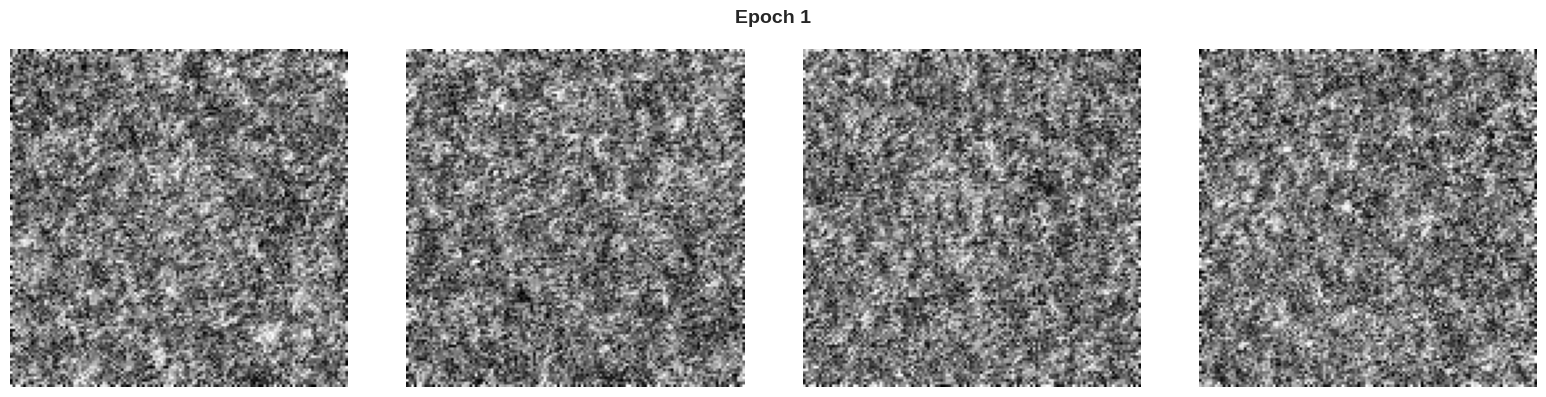

Epoch 2/50:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 2/50 - Loss: 0.0968


Epoch 3/50:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 3/50 - Loss: 0.0667


Epoch 4/50:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 4/50 - Loss: 0.0538


Epoch 5/50:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 5/50 - Loss: 0.0524


Epoch 6/50:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 6/50 - Loss: 0.0380


Epoch 7/50:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 7/50 - Loss: 0.0311


Epoch 8/50:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 8/50 - Loss: 0.0303


Epoch 9/50:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 9/50 - Loss: 0.0259


Epoch 10/50:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 10/50 - Loss: 0.0265


  0%|          | 0/50 [00:00<?, ?it/s]

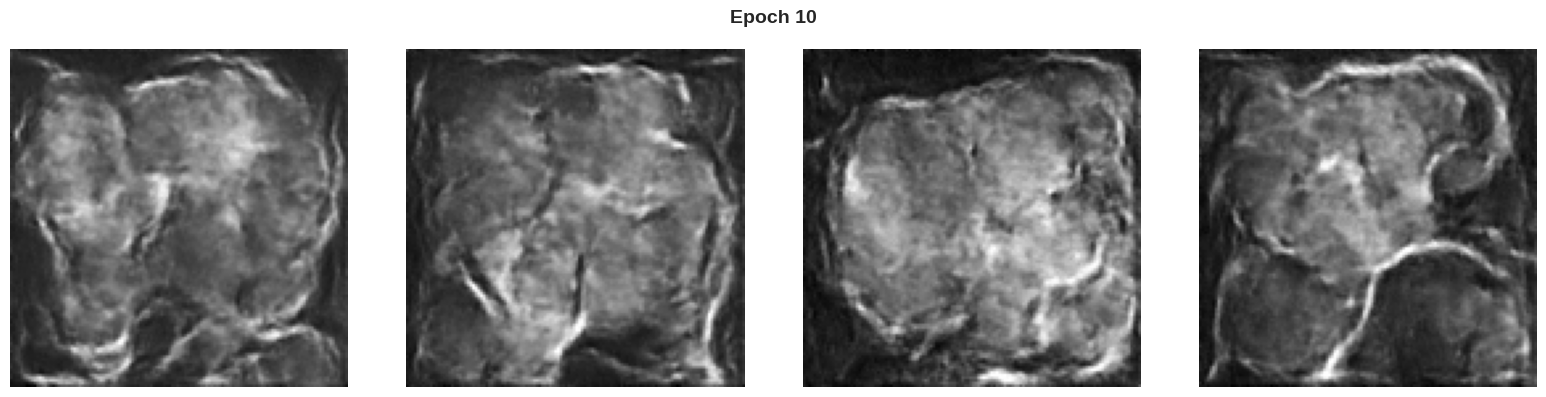

Epoch 11/50:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 11/50 - Loss: 0.0235


Epoch 12/50:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 12/50 - Loss: 0.0315


Epoch 13/50:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 13/50 - Loss: 0.0209


Epoch 14/50:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 14/50 - Loss: 0.0220


Epoch 15/50:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 15/50 - Loss: 0.0165


Epoch 16/50:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 16/50 - Loss: 0.0205


Epoch 17/50:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 17/50 - Loss: 0.0168


Epoch 18/50:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 18/50 - Loss: 0.0253


Epoch 19/50:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 19/50 - Loss: 0.0155


Epoch 20/50:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 20/50 - Loss: 0.0156


  0%|          | 0/50 [00:00<?, ?it/s]

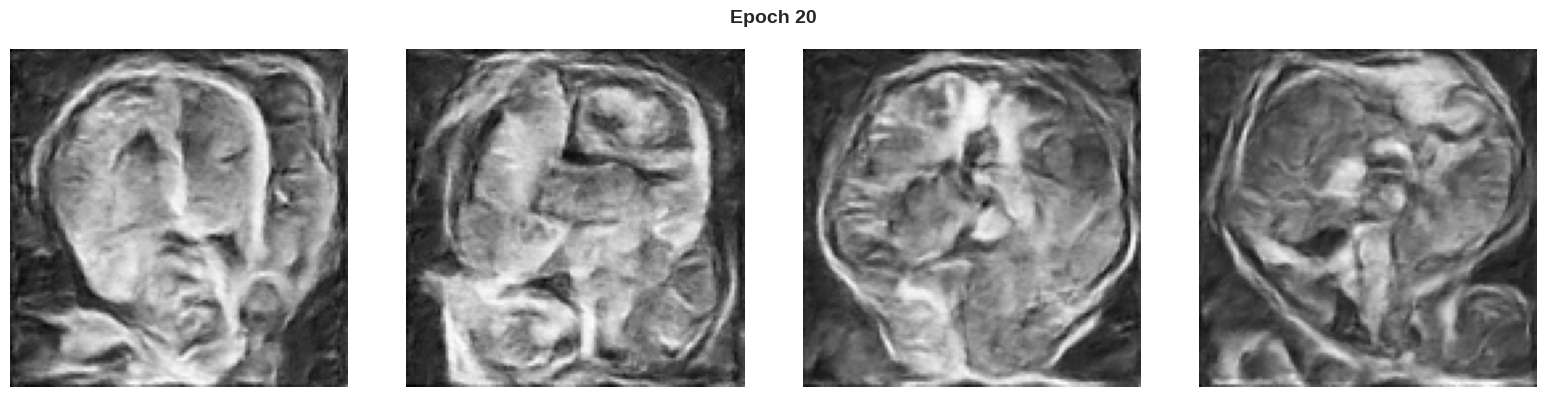

Epoch 21/50:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 21/50 - Loss: 0.0183


Epoch 22/50:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 22/50 - Loss: 0.0158


Epoch 23/50:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 23/50 - Loss: 0.0174


Epoch 24/50:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 24/50 - Loss: 0.0159


Epoch 25/50:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 25/50 - Loss: 0.0159


Epoch 26/50:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 26/50 - Loss: 0.0132


Epoch 27/50:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 27/50 - Loss: 0.0150


Epoch 28/50:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 28/50 - Loss: 0.0142


Epoch 29/50:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 29/50 - Loss: 0.0150


Epoch 30/50:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 30/50 - Loss: 0.0160


  0%|          | 0/50 [00:00<?, ?it/s]

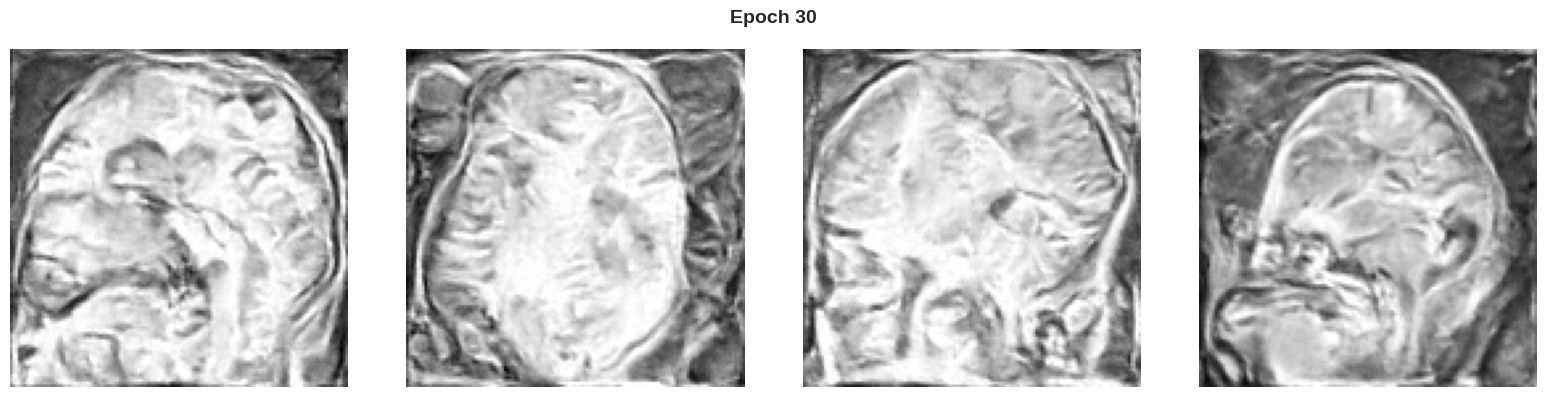

Epoch 31/50:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 31/50 - Loss: 0.0161


Epoch 32/50:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 32/50 - Loss: 0.0156


Epoch 33/50:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 33/50 - Loss: 0.0141


Epoch 34/50:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 34/50 - Loss: 0.0144


Epoch 35/50:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 35/50 - Loss: 0.0148


Epoch 36/50:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 36/50 - Loss: 0.0142


Epoch 37/50:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 37/50 - Loss: 0.0139


Epoch 38/50:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 38/50 - Loss: 0.0161


Epoch 39/50:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 39/50 - Loss: 0.0139


Epoch 40/50:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 40/50 - Loss: 0.0139


  0%|          | 0/50 [00:00<?, ?it/s]

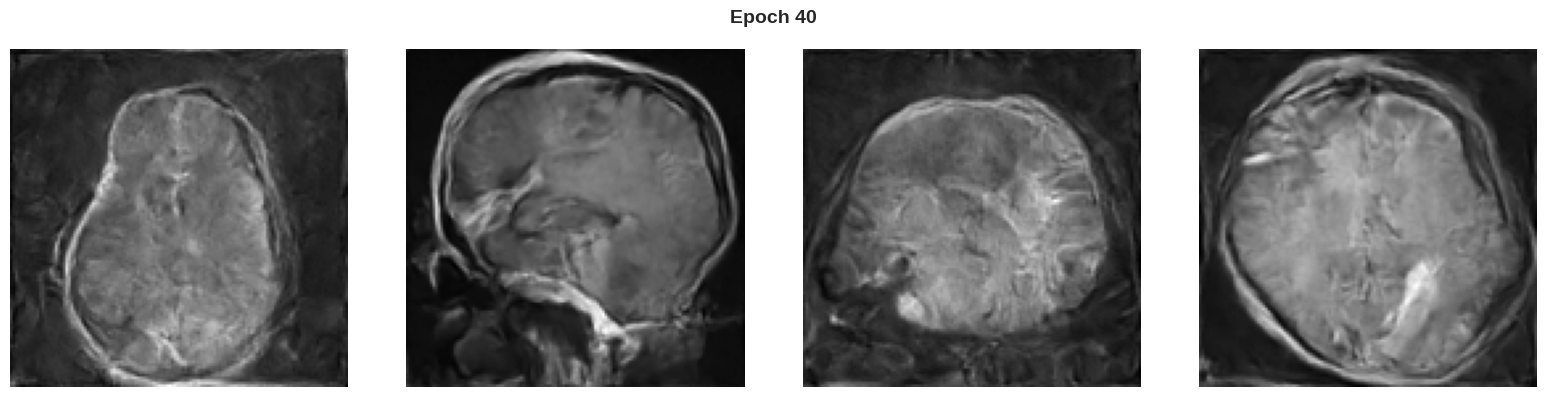

Epoch 41/50:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 41/50 - Loss: 0.0132


Epoch 42/50:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 42/50 - Loss: 0.0129


Epoch 43/50:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 43/50 - Loss: 0.0131


Epoch 44/50:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 44/50 - Loss: 0.0166


Epoch 45/50:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 45/50 - Loss: 0.0133


Epoch 46/50:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 46/50 - Loss: 0.0129


Epoch 47/50:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 47/50 - Loss: 0.0111


Epoch 48/50:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 48/50 - Loss: 0.0131


Epoch 49/50:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 49/50 - Loss: 0.0148


Epoch 50/50:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 50/50 - Loss: 0.0119


  0%|          | 0/50 [00:00<?, ?it/s]

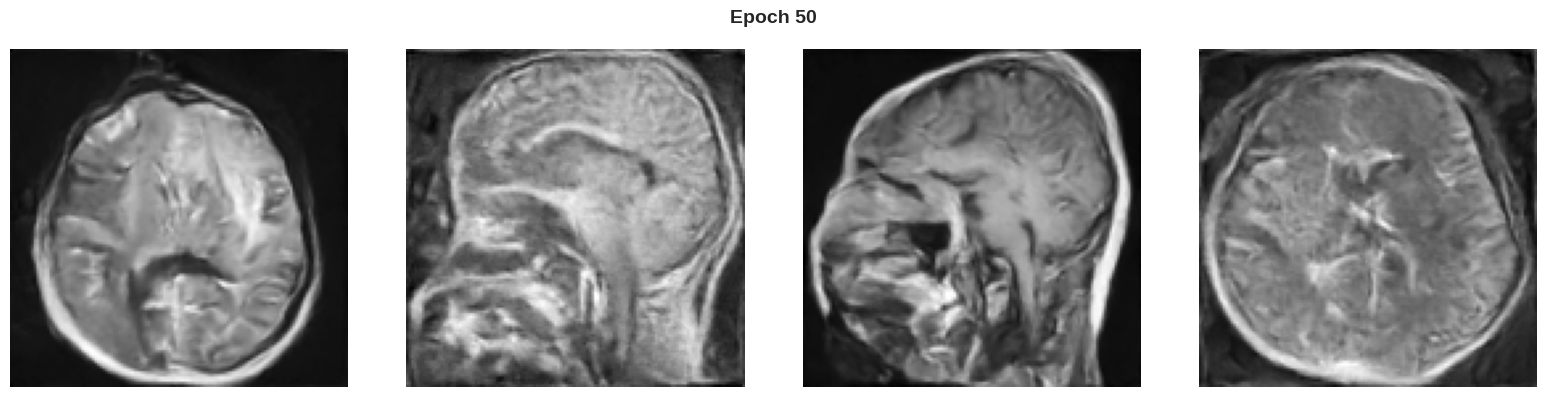


 TRAINING COMPLETED.


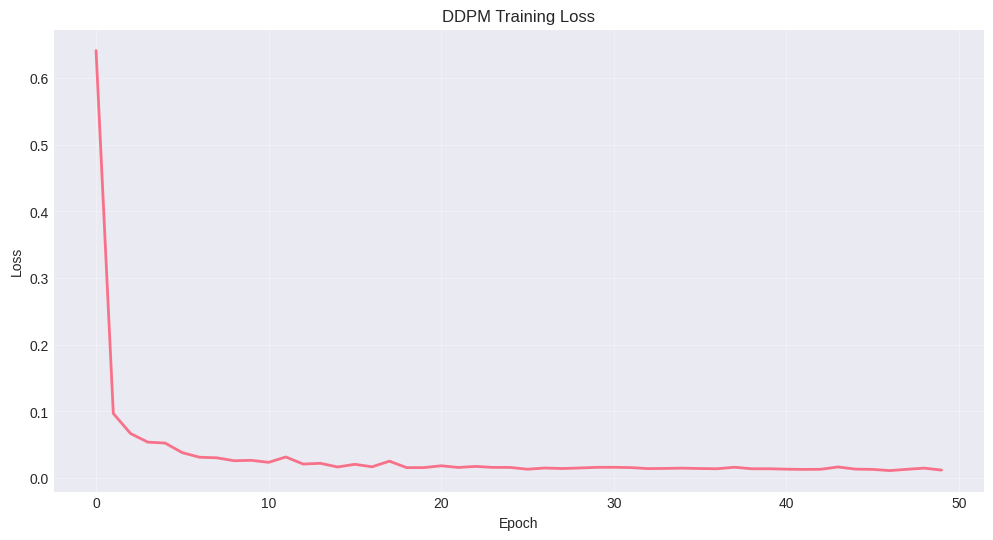

In [25]:
num_epochs = 50
learning_rate = 1e-4

print(f"Configuration:")
print(f"  • Epochs: {num_epochs}")
print(f"  • Learning rate: {learning_rate}")
print(f"  • Batch size: 16")

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=(len(dataloader) * num_epochs),
)

print(f"\n TRAINING STARTING...")

model.train()
losses = []

for epoch in range(num_epochs):
    epoch_loss = 0
    progress_bar = tqdm_auto(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for batch in progress_bar:
        clean_images = batch.to(device)
        noise = torch.randn(clean_images.shape).to(device)
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps,
                                 (clean_images.shape[0],), device=device).long()

        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
        loss = torch.nn.functional.mse_loss(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        epoch_loss += loss.item()
        progress_bar.set_postfix({"loss": loss.item()})

    avg_loss = epoch_loss / len(dataloader)
    losses.append(avg_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}")

    # Échantillons tous les 10 epochs
    if (epoch + 1) % 10 == 0 or epoch == 0:
        model.eval()
        with torch.no_grad():
            pipeline = DDPMPipeline(unet=model, scheduler=noise_scheduler)
            pipeline.to(device)

            samples = pipeline(batch_size=4, num_inference_steps=50, output_type="numpy").images

            fig, axes = plt.subplots(1, 4, figsize=(16, 4))
            fig.suptitle(f'Epoch {epoch+1}', fontsize=14, fontweight='bold')
            for i, ax in enumerate(axes):
                img = (samples[i] * 255).astype(np.uint8)
                ax.imshow(img[:, :, 0], cmap='gray')
                ax.axis('off')

            plt.tight_layout()
            plt.savefig(os.path.join(OUTPUT_BASE, 'samples', f'epoch_{epoch+1:03d}.png'))
            plt.show()

        model.train()

print("\n TRAINING COMPLETED.")

# Courbe loss
plt.figure(figsize=(12, 6))
plt.plot(losses, linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('DDPM Training Loss')
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(OUTPUT_BASE, 'training_loss.png'), dpi=150, bbox_inches='tight')
plt.show()


## **FINAL IMAGE GENERATION**

Images to generate: 205

 Generating images...


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  10/205


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  20/205


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  30/205


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  40/205


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  50/205


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  60/205


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  70/205


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  80/205


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  90/205


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  100/205


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  110/205


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  120/205


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  130/205


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  140/205


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  150/205


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  160/205


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  170/205


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  180/205


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  190/205


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  200/205


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


 205 images generated
 Verification: 205 files

 Comparison...


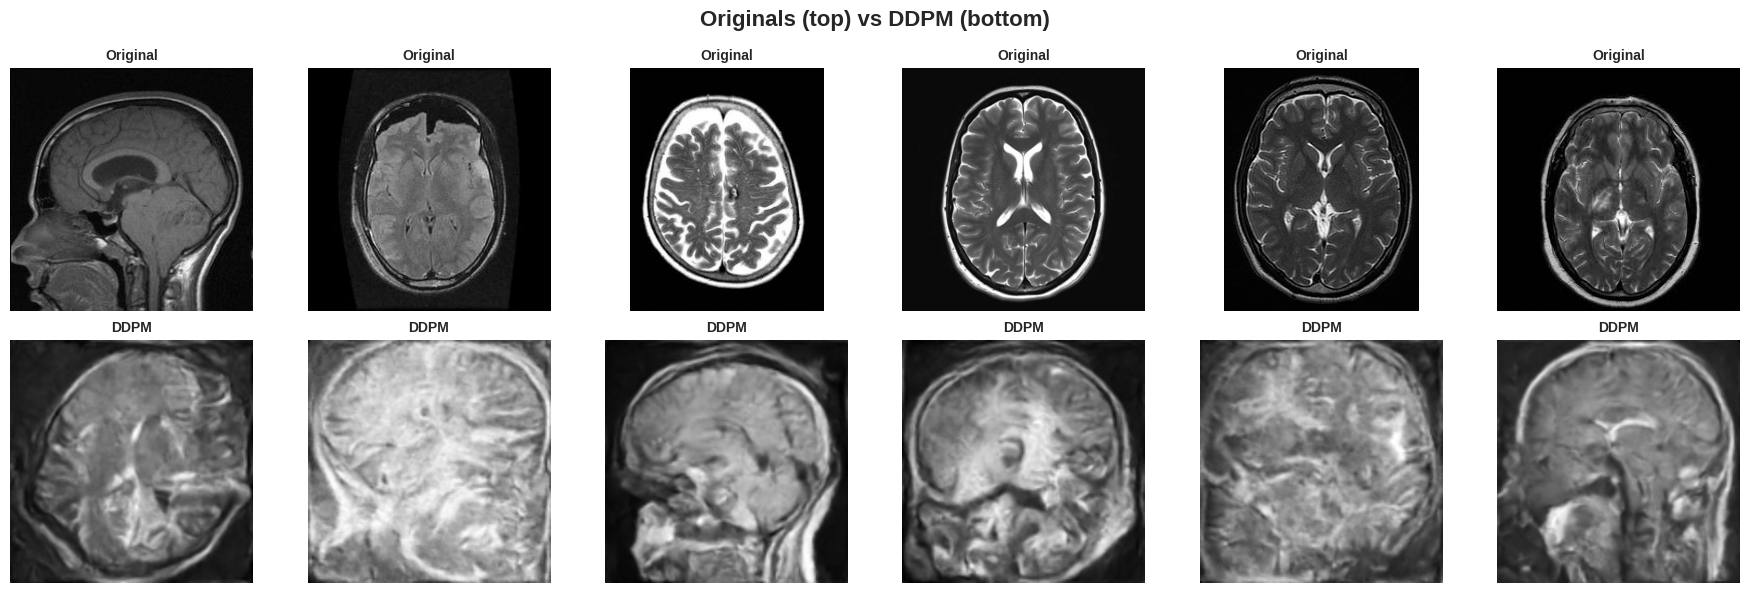

In [27]:
target_total = 600
images_to_generate = target_total - len(no_tumor_images)

print(f"Images to generate: {images_to_generate}")

model.eval()
pipeline = DDPMPipeline(unet=model, scheduler=noise_scheduler)
pipeline.to(device)

generated_folder = os.path.join(OUTPUT_BASE, 'generated_images')
generated_count = 0
batch_size_gen = 4

print("\n Generating images...")

with torch.no_grad():
    while generated_count < images_to_generate:
        try:
            current_batch = min(batch_size_gen, images_to_generate - generated_count)

            output = pipeline(batch_size=current_batch, num_inference_steps=50, output_type="numpy")
            images = output.images

            for i in range(current_batch):
                try:
                    img = (images[i] * 255).astype(np.uint8)
                    img_gray = img[:, :, 0]
                    img_resized = cv2.resize(img_gray, (512, 512))

                    save_path = os.path.join(generated_folder, f'ddpm_{generated_count:04d}.jpg')
                    cv2.imwrite(save_path, img_resized)

                    generated_count += 1

                    if generated_count % 10 == 0:
                        print(f"  {generated_count}/{images_to_generate}")

                except Exception as e:
                    print(f"   Image error {generated_count}: {e}")
                    generated_count += 1

        except Exception as e:
            print(f"   Batch error: {e}")
            if generated_count >= images_to_generate * 0.8:
                break

print(f"\n {generated_count} images generated")

# Verification
saved_imgs = [f for f in os.listdir(generated_folder) if f.lower().endswith('.jpg')]
print(f" Verification: {len(saved_imgs)} files")

# Visual comparison
print("\n Comparison...")

original_samples = no_tumor_images[:6]
generated_samples = saved_imgs[:6]

fig, axes = plt.subplots(2, 6, figsize=(18, 6))
fig.suptitle('Originals (top) vs DDPM (bottom)', fontsize=16, fontweight='bold')

for idx, img_name in enumerate(original_samples):
    img = cv2.imread(os.path.join(temp_no_tumor, img_name), cv2.IMREAD_GRAYSCALE)
    axes[0, idx].imshow(img, cmap='gray')
    axes[0, idx].set_title('Original', fontsize=10, fontweight='bold')
    axes[0, idx].axis('off')

for idx, img_name in enumerate(generated_samples):
    img = cv2.imread(os.path.join(generated_folder, img_name), cv2.IMREAD_GRAYSCALE)
    axes[1, idx].imshow(img, cmap='gray')
    axes[1, idx].set_title('DDPM', fontsize=10, fontweight='bold')
    axes[1, idx].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_BASE, 'comparison.png'), dpi=150, bbox_inches='tight')
plt.show()

## SUMMARY

In [28]:
# SUMMARY
print(f"  • Original images: {len(no_tumor_images)}")
print(f"  • Generated images: {generated_count}")
print(f"  • Total: {len(no_tumor_images) + generated_count}")

  • Original images: 395
  • Generated images: 205
  • Total: 600


## **Data Splitting**

15% of the data from each class is reserved for validation. The original Testing folder is kept for an independent final evaluation. This choice follows best practices in machine learning and avoids information leakage.

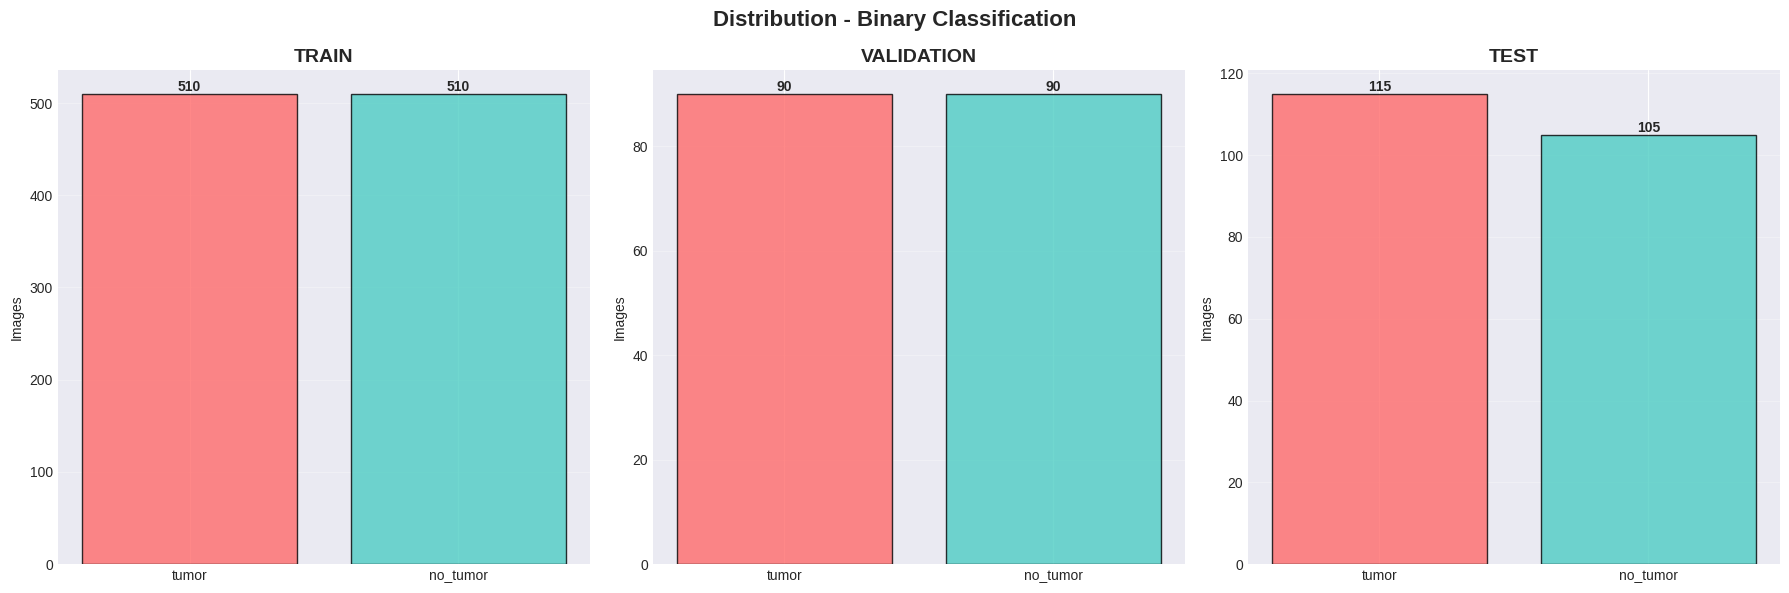

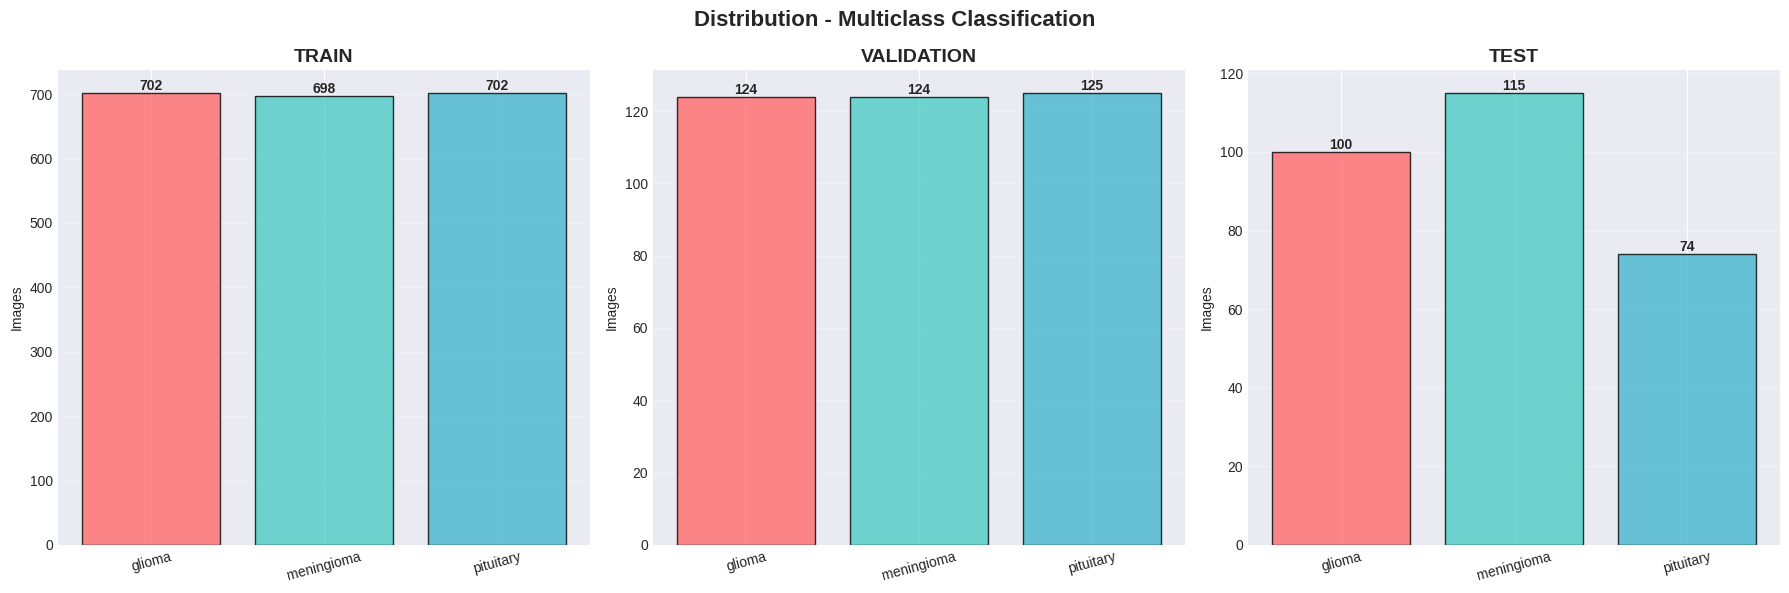


 BINARY CLASSIFICATION:
  train        / tumor     :  510 images
  train        / no_tumor  :  510 images
  validation   / tumor     :   90 images
  validation   / no_tumor  :   90 images
  test         / tumor     :  115 images
  test         / no_tumor  :  105 images

 MULTICLASS CLASSIFICATION:
  train        / glioma     :  702 images
  train        / meningioma :  698 images
  train        / pituitary  :  702 images
  validation   / glioma     :  124 images
  validation   / meningioma :  124 images
  validation   / pituitary  :  125 images
  test         / glioma     :  100 images
  test         / meningioma :  115 images
  test         / pituitary  :   74 images


In [29]:
DATASET = path2
# Count
distribution = {'binary': {}, 'multiclass': {}}

for split in ['train', 'validation', 'test']:
    for class_name in ['tumor', 'no_tumor']:
        path = os.path.join(DATASET, 'binary_classification', split, class_name)
        count = len([f for f in os.listdir(path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        if split not in distribution['binary']:
            distribution['binary'][split] = {}
        distribution['binary'][split][class_name] = count

for split in ['train', 'validation', 'test']:
    for class_name in ['glioma', 'meningioma', 'pituitary']:
        path = os.path.join(DATASET, 'multiclass_classification', split, class_name)
        count = len([f for f in os.listdir(path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        if split not in distribution['multiclass']:
            distribution['multiclass'][split] = {}
        distribution['multiclass'][split][class_name] = count

# Plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Distribution - Binary Classification', fontsize=16, fontweight='bold')

for idx, split in enumerate(['train', 'validation', 'test']):
    data = distribution['binary'][split]
    axes[idx].bar(data.keys(), data.values(), color=['#FF6B6B', '#4ECDC4'], alpha=0.8, edgecolor='black')
    axes[idx].set_title(f'{split.upper()}', fontsize=14, fontweight='bold')
    axes[idx].set_ylabel('Images')
    axes[idx].grid(True, alpha=0.3, axis='y')

    for i, (k, v) in enumerate(data.items()):
        axes[idx].text(i, v, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Multi-class
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Distribution - Multiclass Classification', fontsize=16, fontweight='bold')

for idx, split in enumerate(['train', 'validation', 'test']):
    data = distribution['multiclass'][split]
    axes[idx].bar(data.keys(), data.values(), color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.8, edgecolor='black')
    axes[idx].set_title(f'{split.upper()}', fontsize=14, fontweight='bold')
    axes[idx].set_ylabel('Images')
    axes[idx].grid(True, alpha=0.3, axis='y')
    axes[idx].tick_params(axis='x', rotation=15)

    for i, (k, v) in enumerate(data.items()):
        axes[idx].text(i, v, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n BINARY CLASSIFICATION:")
for split in ['train', 'validation', 'test']:
    for class_name in ['tumor', 'no_tumor']:
        count = distribution['binary'][split][class_name]
        print(f"  {split:12s} / {class_name:10s}: {count:4d} images")

print("\n MULTICLASS CLASSIFICATION:")
for split in ['train', 'validation', 'test']:
    for class_name in ['glioma', 'meningioma', 'pituitary']:
        count = distribution['multiclass'][split][class_name]
        print(f"  {split:12s} / {class_name:11s}: {count:4d} images")

## DATA MODELLING

**Objectives of the Modeling Phase:**

The modeling phase aims to design, train, and compare several Deep Learning models to identify the most effective architecture for the classification of brain MRI images. In accordance with the CRISP-DM methodology, this phase directly builds upon the decisions made during data preparation.

Two modeling objectives are pursued:

 - Binary classification: distinguishing patients with a brain tumor (tumor) from those without a tumor (no_tumor).

 - Conditional multi-class classification: identifying the type of tumor (Glioma, Meningioma, or Pituitary) only when the presence of a tumor is detected.

This section focuses on the comparative study of Transfer Learning models, which are particularly well-suited to limited-size medical datasets.

**Transfer Learning and Medical Imaging**

Training a deep convolutional neural network from scratch requires a massive volume of data, which is rarely available in medical imaging. Transfer Learning involves leveraging pre-trained models on large datasets (such as ImageNet) to transfer the learned knowledge to a new task.

In medical imaging, this approach offers several advantages:

- Reduced training time.

- Improved model convergence.

- Enhanced performance despite a limited number of annotated images.

Numerous studies have shown that the initial layers of a CNN learn generic features (edges, textures), which are also useful for MRI images.

**Selected Models:**

Two reference architectures were selected: EfficientNetB0 and DenseNet121. This choice is based on their proven effectiveness in recent work in medical imaging.

**1. EfficientNetB0**

EfficientNet is based on a compound scaling principle, which simultaneously balances:

 - the network depth,
 - the layer width,
 - the image resolution.

EfficientNetB0 is the base version of this family, offering an excellent compromise between performance, number of parameters, and computational cost.

These characteristics make it a model particularly well-suited to resource-constrained environments and medical databases.

**2. DenseNet121**

 DenseNet121 belongs to the family of densely connected networks. Each layer receives as input the feature maps from all previous layers.

The main advantages of DenseNet121 are:
 - improved gradient propagation,
 - efficient feature reuse,
 - reduced risk of overfitting.

These properties are particularly valuable for detecting fine and complex structures, typical of MRI images.

**Training Strategies**

For each architecture, three Transfer Learning strategies were implemented to evaluate their impact on performance.

**Mode 1: Feature Extraction**

In this mode:

The weights of the pre-trained model are completely frozen.

Only the final layers (classifier) ​​are trained.

**Advantages**: Fast training, limited risk of overfitting.

**Limitations**: Restricted adaptation to the specific characteristics of MRI images.

This mode serves as a baseline for comparison.

**Mode 2: Full Fine-tuning**

In this mode:

All layers of the model are trained.

The pre-trained weights are used only for initialization.

**Advantages**: Complete adaptation to MRI data, maximum performance potential.

**Limitations**: Increased risk of overfitting, higher computational cost.

This strategy is relevant when the data is sufficiently diverse, particularly through data augmentation using diffusion models.

**Mode 3: Partial Fine-tuning**

Partial fine-tuning represents a compromise between the two previous approaches:

- The first (low-level) layers are frozen.

- The deeper layers are retrained.

**Advantages**: Preservation of generic features, targeted adaptation to specific tumor patterns, and better bias/variance trade-off.
 This approach is often considered most suitable in medical imaging.

In [30]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, optimizers
import warnings
warnings.filterwarnings('ignore')

### **Configuration and Data Loading**

In [31]:

# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
BASE_PATH = path2

# Preprocessing: EfficientNet handles internal scaling,
# but we apply data augmentation to limit overfitting.
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

test_val_datagen = ImageDataGenerator() # No augmentation for val/test

# 1. Binary Generators
train_gen_bin = train_datagen.flow_from_directory(
    os.path.join(BASE_PATH, 'binary_classification/train'),
    target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary')

val_gen_bin = test_val_datagen.flow_from_directory(
    os.path.join(BASE_PATH, 'binary_classification/validation'),
    target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary', shuffle=False)

# 2. Multiclass Generators
train_gen_multi = train_datagen.flow_from_directory(
    os.path.join(BASE_PATH, 'multiclass_classification/train'),
    target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')

val_gen_multi = test_val_datagen.flow_from_directory(
    os.path.join(BASE_PATH, 'multiclass_classification/validation'),
    target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

Found 1020 images belonging to 2 classes.
Found 180 images belonging to 2 classes.
Found 2102 images belonging to 3 classes.
Found 373 images belonging to 3 classes.


### **Building the EfficientNetB0 Transfer Learning Model**

In [32]:
def build_efficientnet_model(num_classes, activation):
    # Load the EfficientNetB0 base pre-trained on ImageNet
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze weights initially

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(rate=0.2),
        layers.Dense(num_classes, activation=activation)

    ])

    return model

### **Binary Classification Model (Feature Extraction):**

In [33]:
# Model 1: Binary (Tumor vs No Tumor)
model_bin = build_efficientnet_model(1, 'sigmoid')
model_bin.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [34]:
history_bin = model_bin.fit(
    train_gen_bin,
    validation_data=val_gen_bin,
    epochs=10
)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.7187 - loss: 5.8343 - precision: 0.7289 - recall: 0.7030 - val_accuracy: 0.9000 - val_loss: 0.5846 - val_precision: 0.9737 - val_recall: 0.8222
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 429ms/step - accuracy: 0.8787 - loss: 0.7366 - precision: 0.9047 - recall: 0.8591 - val_accuracy: 0.9389 - val_loss: 0.2018 - val_precision: 0.9247 - val_recall: 0.9556
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 433ms/step - accuracy: 0.9354 - loss: 0.2299 - precision: 0.9422 - recall: 0.9268 - val_accuracy: 0.9500 - val_loss: 0.1623 - val_precision: 0.9175 - val_recall: 0.9889
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 455ms/step - accuracy: 0.9685 - loss: 0.0978 - precision: 0.9704 - recall: 0.9670 - val_accuracy: 0.9500 - val_loss: 0.1218 - val_precision: 0.9451 - val_recall: 0.9556
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 434ms/step - accuracy: 0.9656 - loss: 0.0757 - precision: 0.9713 - recall: 0.9588 - val_accuracy: 0.9722 - val_loss: 

In [35]:
import matplotlib.pyplot as plt

def plot_training_history(history, title="Training Evolution"):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    # Accuracy Graph
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', color='#2ecc71', marker='o')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='#e74c3c', marker='s')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend(loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.6)

    # Loss Graph
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', color='#2ecc71', marker='o')
    plt.plot(epochs_range, val_loss, label='Validation Loss', color='#e74c3c', marker='s')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss Value')
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

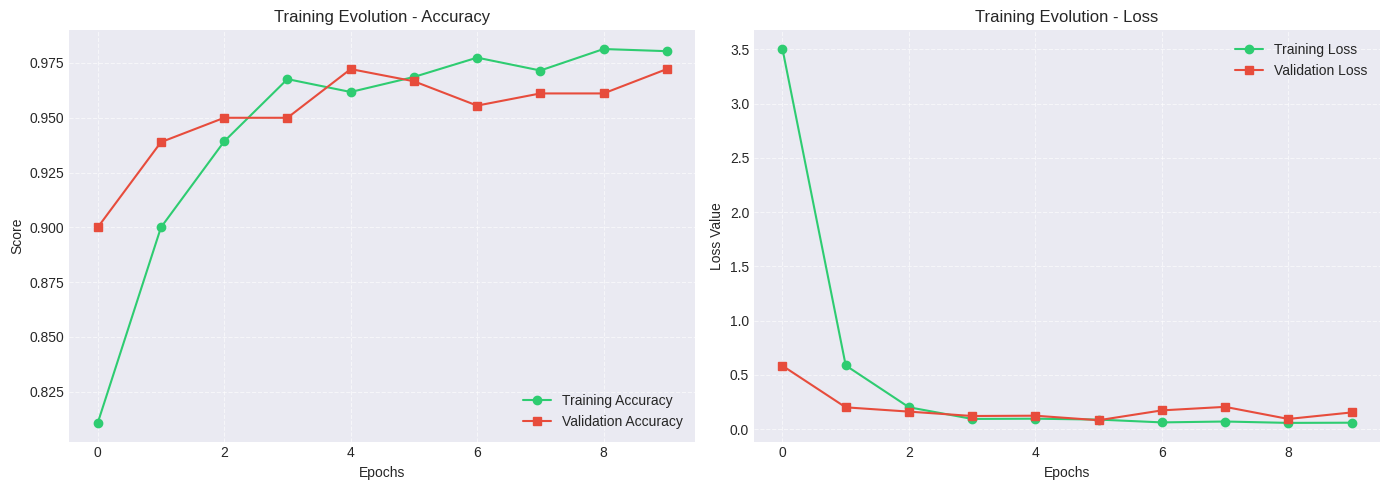

In [36]:
# loss and Accuracy curves
plot_training_history(history_bin, title="Training Evolution")

In [37]:
# Evaluation and Confusion Matrix

def evaluate_and_plot(model, generator, labels, title):
    # Predictions
    preds = model.predict(generator)
    if len(labels) == 2: # Binary case
        y_pred = (preds > 0.5).astype(int).flatten()
    else: # Multi-class case
        y_pred = np.argmax(preds, axis=1)

    y_true = generator.classes

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix: {title}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Classification Report (Precision, Recall, F1)
    print(f"--- Classification Report: {title} ---")
    print(classification_report(y_true, y_pred, target_names=labels))

6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step


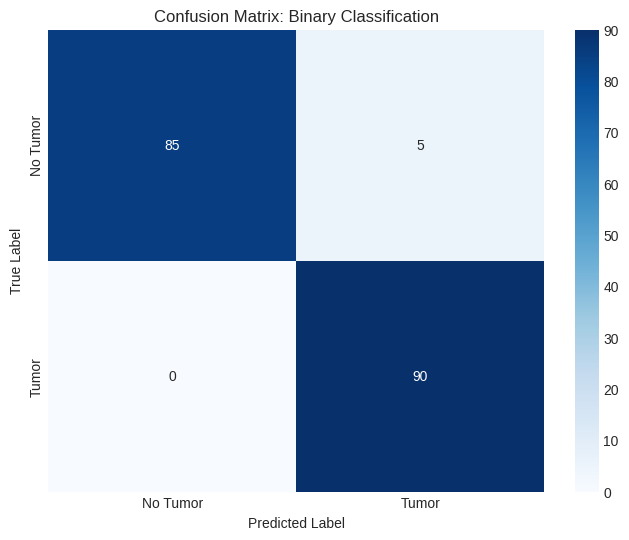

--- Classification Report: Binary Classification ---
              precision    recall  f1-score   support

    No Tumor       1.00      0.94      0.97        90
       Tumor       0.95      1.00      0.97        90

    accuracy                           0.97       180
   macro avg       0.97      0.97      0.97       180
weighted avg       0.97      0.97      0.97       180



In [38]:
# Display for binary classification
evaluate_and_plot(model_bin, val_gen_bin, ['No Tumor', 'Tumor'], "Binary Classification")

In [39]:
model_bin.save('model_bin.h5')

### **Multi-class Classification Model (Feature Extraction):**

In [40]:
# Model 2: Multi-class (Glioma, Meningioma, Pituitary)
model_multi = build_efficientnet_model(3, 'softmax')
model_multi.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [41]:
# Training the multi-class model
history_multi = model_multi.fit(
    train_gen_multi,
    validation_data=val_gen_multi,
    epochs=10
)

Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.5565 - loss: 9.7525 - precision_1: 0.5610 - recall_1: 0.5511 - val_accuracy: 0.7775 - val_loss: 0.4973 - val_precision_1: 0.8011 - val_recall_1: 0.7560
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 425ms/step - accuracy: 0.8158 - loss: 0.4812 - precision_1: 0.8280 - recall_1: 0.7892 - val_accuracy: 0.8499 - val_loss: 0.4100 - val_precision_1: 0.8603 - val_recall_1: 0.8257
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 29s 438ms/step - accuracy: 0.8558 - loss: 0.3635 - precision_1: 0.8689 - recall_1: 0.8353 - val_accuracy: 0.8499 - val_loss: 0.3426 - val_precision_1: 0.8529 - val_recall_1: 0.8391
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 422ms/step - accuracy: 0.8674 - loss: 0.3470 - precision_1: 0.8733 - recall_1: 0.8536 - val_accuracy: 0.8928 - val_loss: 0.3065 - val_precision_1: 0.8946 - val_recall_1: 0.8874
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 423ms/step - accuracy: 0.8999 - loss: 0.2794 - precision_1: 0.9084 - recall_1: 0.8908

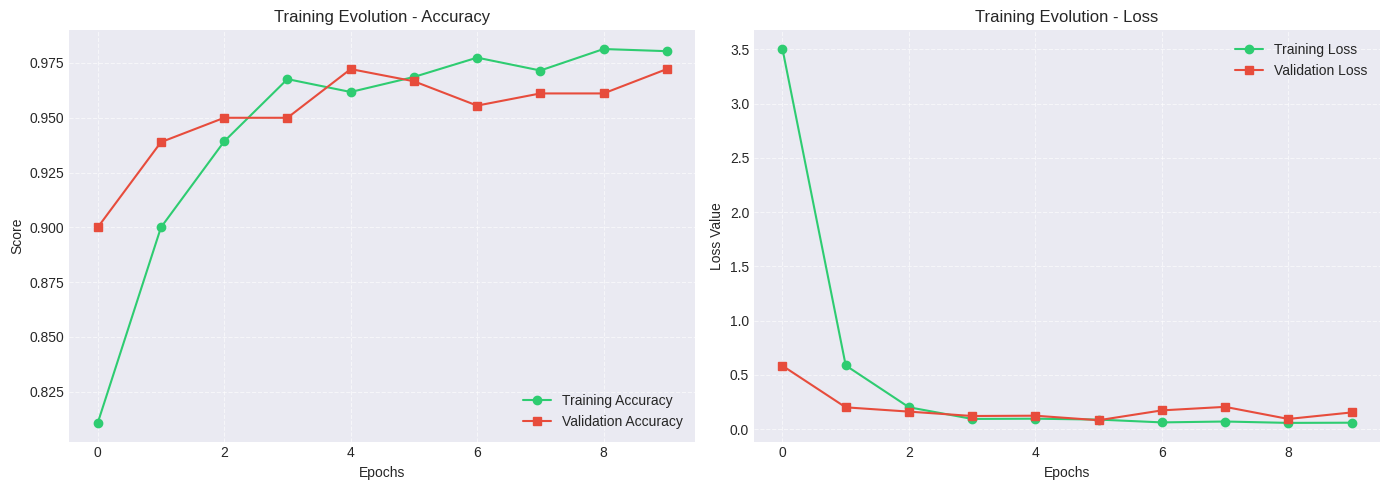

In [42]:
# Loss and Accuracy curves
plot_training_history(history_bin, title="Training Evolution")

12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 692ms/step


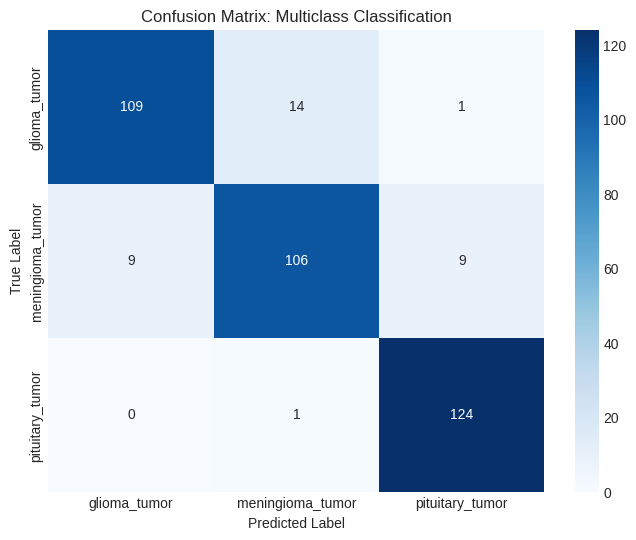

--- Classification Report: Multiclass Classification ---
                  precision    recall  f1-score   support

    glioma_tumor       0.92      0.88      0.90       124
meningioma_tumor       0.88      0.85      0.87       124
 pituitary_tumor       0.93      0.99      0.96       125

        accuracy                           0.91       373
       macro avg       0.91      0.91      0.91       373
    weighted avg       0.91      0.91      0.91       373



In [43]:
# Evaluate the multi-class classification model
evaluate_and_plot(model_multi, val_gen_multi, ['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor'], "Multiclass Classification")

### **Total fine-tuning for the multi-class model**

In [44]:
# Unfreeze the base model
def build_efficientnet_model(num_classes, activation):
    # Load the EfficientNetB0 base pre-trained on ImageNet
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = True  # Unfreeze weights initially

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(rate=0.2),
        layers.Dense(num_classes, activation=activation)
    ])

    return model

In [45]:
# Model 3: Multi-class (Glioma, Meningioma, Pituitary) with Fine Tuning
model_multi_fine = build_efficientnet_model(3, 'softmax')
model_multi_fine.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [46]:
callbacks = [
    # Stops training if validation loss does not decrease for 3 epochs
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss'),
    # Reduces LR if the model plateaus
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7)
]

In [47]:
# Launching Fine-tuning
history_fine = model_multi_fine.fit(
    train_gen_multi,
    validation_data=val_gen_multi,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - accuracy: 0.5862 - loss: 0.9503 - precision_2: 0.6306 - recall_2: 0.5514 - val_accuracy: 0.7185 - val_loss: 0.6925 - val_precision_2: 0.7443 - val_recall_2: 0.7024 - learning_rate: 1.0000e-05
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 31s 463ms/step - accuracy: 0.8142 - loss: 0.5025 - precision_2: 0.8331 - recall_2: 0.7965 - val_accuracy: 0.8338 - val_loss: 0.4481 - val_precision_2: 0.8430 - val_recall_2: 0.8204 - learning_rate: 1.0000e-05
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 31s 462ms/step - accuracy: 0.8375 - loss: 0.3948 - precision_2: 0.8482 - recall_2: 0.8277 - val_accuracy: 0.8740 - val_loss: 0.3716 - val_precision_2: 0.8822 - val_recall_2: 0.8633 - learning_rate: 1.0000e-05
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 30s 450ms/step - accuracy: 0.8785 - loss: 0.3187 - precision_2: 0.8866 - recall_2: 0.8734 - val_accuracy: 0.8713 - val_loss: 0.3722 - val_precision_2: 0.8828 - val_recall_2: 0.8686 - learning_rate: 1.0000e-05
Epoch 5/10
66/

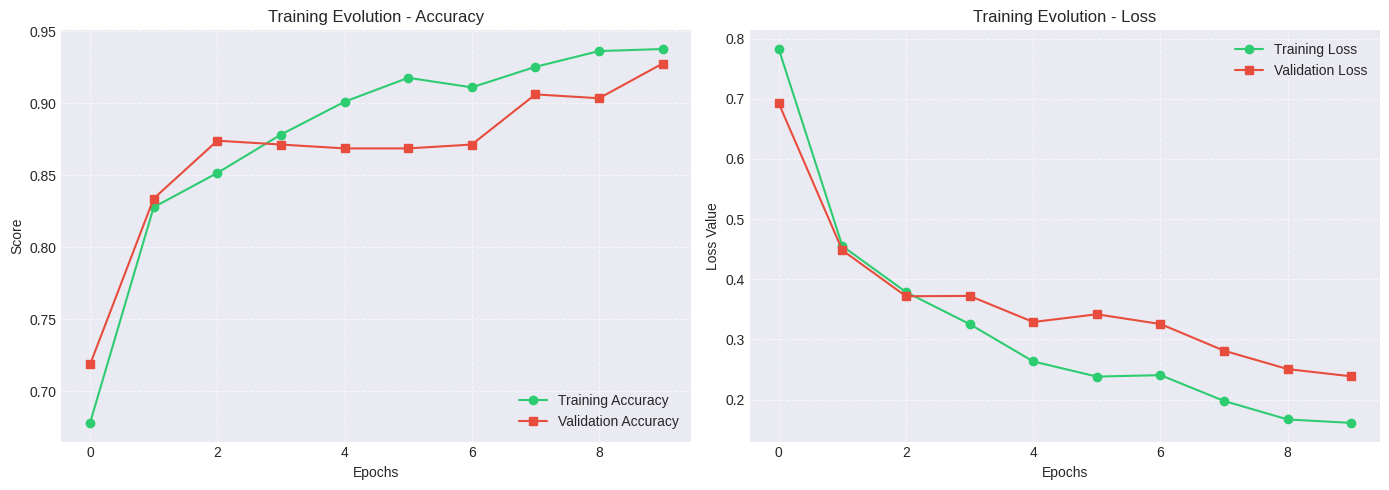

In [48]:
plot_training_history(history_fine, title="Training Evolution")

12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 703ms/step


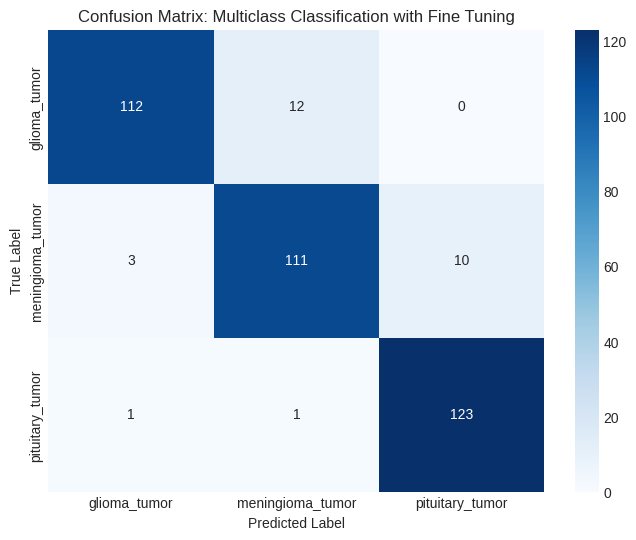

--- Classification Report: Multiclass Classification with Fine Tuning ---
                  precision    recall  f1-score   support

    glioma_tumor       0.97      0.90      0.93       124
meningioma_tumor       0.90      0.90      0.90       124
 pituitary_tumor       0.92      0.98      0.95       125

        accuracy                           0.93       373
       macro avg       0.93      0.93      0.93       373
    weighted avg       0.93      0.93      0.93       373



In [49]:
# Evaluation and Confusion Matrix
# Display for multiclass
evaluate_and_plot(model_multi_fine, val_gen_multi, ['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor'], "Multiclass Classification with Fine Tuning")

### **Partial fine-tuning for the multi-class model**

In [50]:
# Unfreeze the base model
def build_efficientnet_model(num_classes, activation):
    # Load the EfficientNetB0 base pre-trained on ImageNet
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # We chose to train 78 layers,
    # meaning we will freeze
    # the first 160 layers and unfreeze the rest:
    for layer in base_model.layers[:160]:
        layer.trainable = False
    for layer in base_model.layers[160:]:
        layer.trainable = True

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(rate=0.2),
        layers.Dense(num_classes, activation=activation)
    ])

    return model

In [51]:
# Model 3: Multi-class (Glioma, Meningioma, Pituitary) with Fine Tuning
model_multi_fine = build_efficientnet_model(3, 'softmax')
model_multi_fine.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [52]:
callbacks = [
    # Stops training if validation loss does not decrease for 3 epochs
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss'),
    # Reduces LR if the model plateaus
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7)
]

In [53]:
# Launching Fine-tuning
history_fine = model_multi_fine.fit(
    train_gen_multi,
    validation_data=val_gen_multi,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 95s 894ms/step - accuracy: 0.5558 - loss: 1.0530 - precision_3: 0.5766 - recall_3: 0.4987 - val_accuracy: 0.7909 - val_loss: 0.4919 - val_precision_3: 0.8040 - val_recall_3: 0.7587 - learning_rate: 1.0000e-05
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 33s 439ms/step - accuracy: 0.7980 - loss: 0.4918 - precision_3: 0.8101 - recall_3: 0.7835 - val_accuracy: 0.8123 - val_loss: 0.4219 - val_precision_3: 0.8224 - val_recall_3: 0.8070 - learning_rate: 1.0000e-05
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 30s 448ms/step - accuracy: 0.8431 - loss: 0.4283 - precision_3: 0.8487 - recall_3: 0.8331 - val_accuracy: 0.8740 - val_loss: 0.3027 - val_precision_3: 0.8777 - val_recall_3: 0.8660 - learning_rate: 1.0000e-05
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 429ms/step - accuracy: 0.8584 - loss: 0.3714 - precision_3: 0.8661 - recall_3: 0.8489 - val_accuracy: 0.8794 - val_loss: 0.3054 - val_precision_3: 0.8804 - val_recall_3: 0.8686 - learning_rate: 1.0000e-05
Epoch 5/10
6

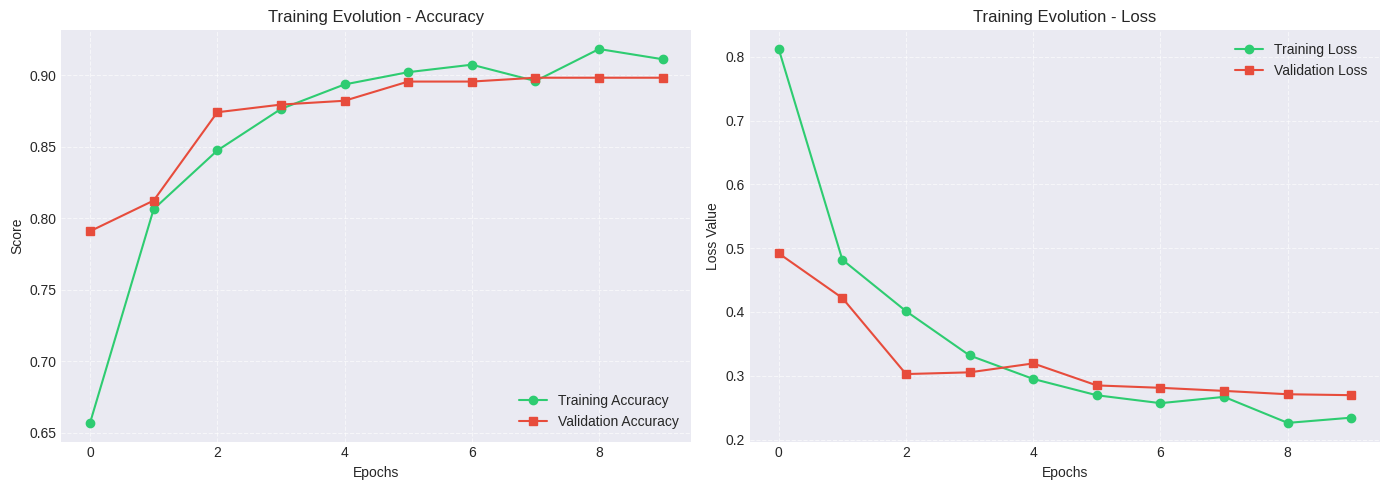

In [54]:
plot_training_history(history_fine, title="Training Evolution")

12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 713ms/step


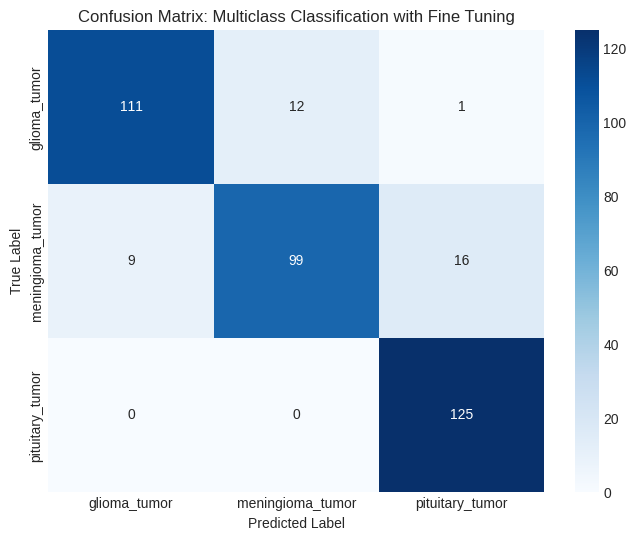

--- Classification Report: Multiclass Classification with Fine Tuning ---
                  precision    recall  f1-score   support

    glioma_tumor       0.93      0.90      0.91       124
meningioma_tumor       0.89      0.80      0.84       124
 pituitary_tumor       0.88      1.00      0.94       125

        accuracy                           0.90       373
       macro avg       0.90      0.90      0.90       373
    weighted avg       0.90      0.90      0.90       373



In [55]:
# Evaluation and Confusion Matrix
# Display for multiclass
evaluate_and_plot(model_multi_fine, val_gen_multi, ['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor'], "Multiclass Classification with Fine Tuning")

In [56]:
model_multi_fine.save('model_multi_fine_partial.h5') # Saving the multiclass model

In [57]:
# Final decision pipeline

def diagnostic_pipeline(image_path, model_bin, model_multi_fine):
    # 1. Load and prepare the image
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # 2. Step 1: Tumor detection (Binary)
    is_tumor_prob = model_bin.predict(img_array)[0][0]

    if is_tumor_prob < 0.5:
        return "Result: No tumor detected."
    else:
        # 3. Step 2: If tumor, classify the type (Multi-class)
        type_preds = model_multi.predict(img_array)
        classes_multi = ['Glioma', 'Meningioma', 'Pituitary']
        detected_type = classes_multi[np.argmax(type_preds)]
        return f"Result: Tumor detected. Suspected type: {detected_type} (Confidence: {np.max(type_preds)*100:.2f}%)"

In [58]:
from tensorflow.keras.models import load_model

test_img_path = '/kaggle/input/brain-tumor-balanced/multiclass_classification/test/pituitary/image(10).jpg'
binary_model = load_model('/content/model_bin.h5')
multi_model = load_model('/content/model_multi_fine_partial.h5')
diagnostic_pipeline(test_img_path, binary_model, multi_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


'Result: Tumor detected. Suspected type: Pituitary (Confidence: 100.00%)'

## **Construction of the transfer learning model DenseNet121**

In [59]:
from tensorflow.keras.applications import DenseNet121

def build_densenet_model(num_classes, activation):
    # Load pre-trained DenseNet121
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False # Freeze for initial transfer

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(rate=0.2),
        layers.Dense(num_classes, activation=activation)
    ])

    return model

### **Binary Model with DenseNet121**

In [60]:
# Create the binary model
model_bin_dense = build_densenet_model(1, 'sigmoid')
model_bin_dense.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [61]:
history_bin_dense = model_bin_dense.fit(
    train_gen_bin,
    validation_data=val_gen_bin,
    epochs=10
)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.6375 - loss: 46.9980 - precision_4: 0.6502 - recall_4: 0.6225 - val_accuracy: 0.8111 - val_loss: 6.8092 - val_precision_4: 0.7500 - val_recall_4: 0.9333
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 454ms/step - accuracy: 0.8577 - loss: 5.0199 - precision_4: 0.8494 - recall_4: 0.8578 - val_accuracy: 0.8167 - val_loss: 3.9623 - val_precision_4: 0.7436 - val_recall_4: 0.9667
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 464ms/step - accuracy: 0.8371 - loss: 3.9838 - precision_4: 0.8164 - recall_4: 0.8602 - val_accuracy: 0.9111 - val_loss: 1.2844 - val_precision_4: 0.9512 - val_recall_4: 0.8667
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 460ms/step - accuracy: 0.8950 - loss: 1.3898 - precision_4: 0.9074 - recall_4: 0.8725 - val_accuracy: 0.8389 - val_loss: 1.0707 - val_precision_4: 0.7607 - val_recall_4: 0.9889
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 478ms/step - accuracy: 0.8771 - loss: 0.8023 - precision_4: 0.8758 - recall_4: 0.887

In [62]:
model_bin_dense.save('model_bin_dense.h5') # Saving the binary model

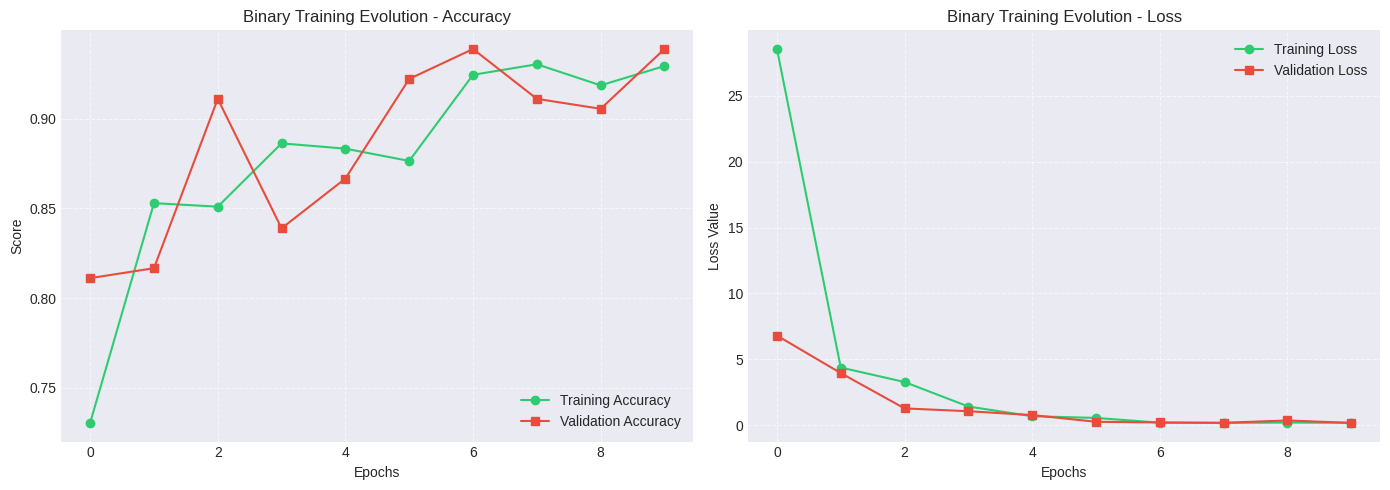

In [63]:
# Loss and Accuracy curves
plot_training_history(history_bin_dense, title="Binary Training Evolution")

5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step

6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step


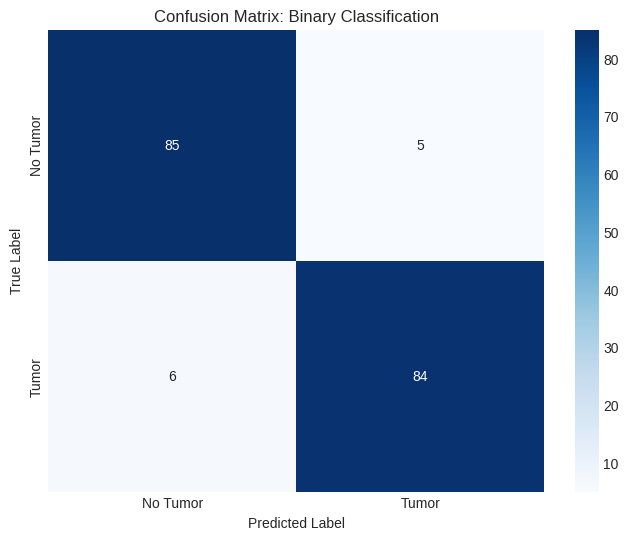

--- Classification Report: Binary Classification ---
              precision    recall  f1-score   support

    No Tumor       0.93      0.94      0.94        90
       Tumor       0.94      0.93      0.94        90

    accuracy                           0.94       180
   macro avg       0.94      0.94      0.94       180
weighted avg       0.94      0.94      0.94       180



In [64]:
# Display for binary
evaluate_and_plot(model_bin_dense, val_gen_bin, ['No Tumor', 'Tumor'], "Binary Classification")

### **Multi-class model with DenseNet121 (feature extraction)**

In [65]:
# Create the multi-class model
model_multi_dense = build_densenet_model(3, 'softmax')
model_multi_dense.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [66]:
# Training the multi-class model
history_multi_dense = model_multi_dense.fit(
    train_gen_multi,
    validation_data=val_gen_multi,
    epochs=10
)

Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.4526 - loss: 50.7551 - precision_5: 0.4527 - recall_5: 0.4526 - val_accuracy: 0.7239 - val_loss: 0.9687 - val_precision_5: 0.7290 - val_recall_5: 0.7212
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 30s 453ms/step - accuracy: 0.7384 - loss: 0.7357 - precision_5: 0.7757 - recall_5: 0.6941 - val_accuracy: 0.7882 - val_loss: 0.5823 - val_precision_5: 0.8214 - val_recall_5: 0.7399
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 31s 463ms/step - accuracy: 0.7793 - loss: 0.5558 - precision_5: 0.8177 - recall_5: 0.7265 - val_accuracy: 0.7936 - val_loss: 0.6159 - val_precision_5: 0.8017 - val_recall_5: 0.7802
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 30s 454ms/step - accuracy: 0.7993 - loss: 0.4817 - precision_5: 0.8255 - recall_5: 0.7665 - val_accuracy: 0.8365 - val_loss: 0.4675 - val_precision_5: 0.8451 - val_recall_5: 0.8043
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 30s 459ms/step - accuracy: 0.8004 - loss: 0.5018 - precision_5: 0.8226 - recall_5: 0.758

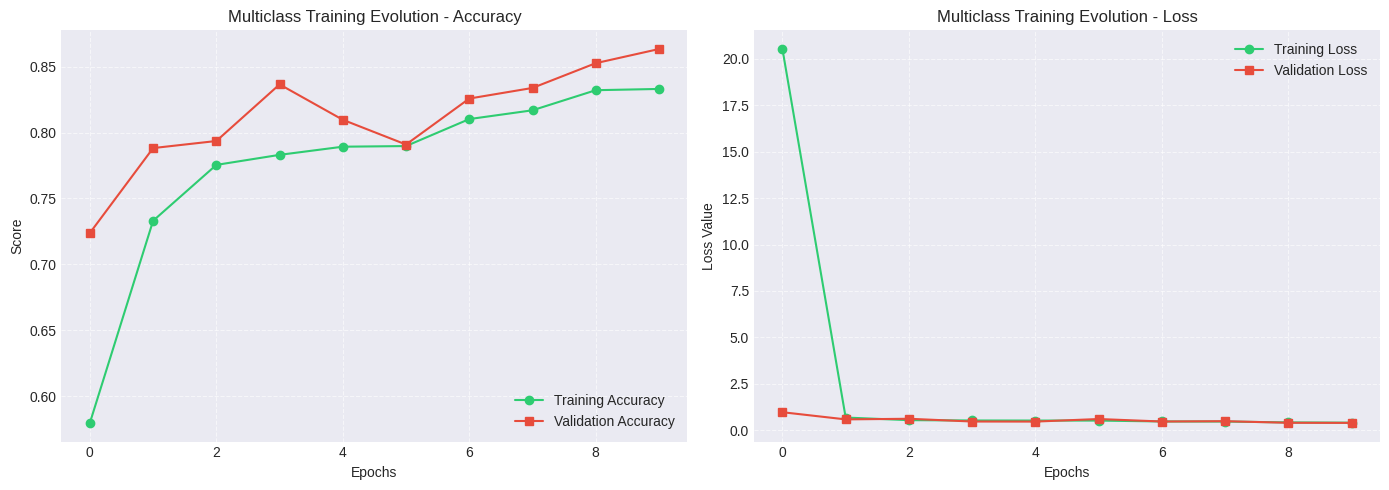

In [67]:
# Loss and Accuracy curves
plot_training_history(history_multi_dense, title="Multiclass Training Evolution")

12/12 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step


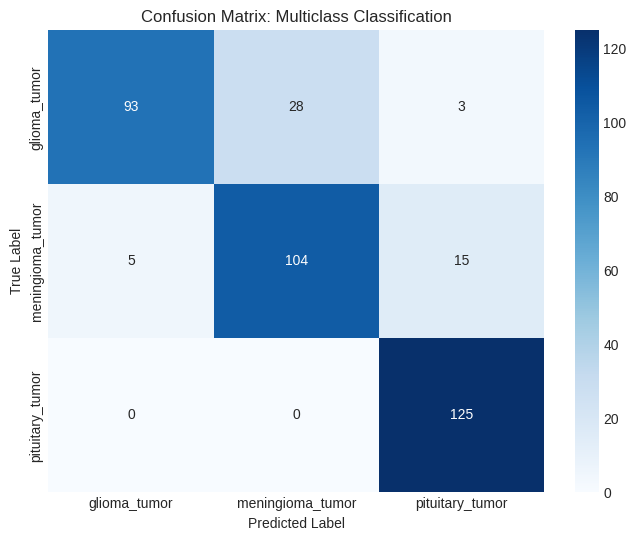

--- Classification Report: Multiclass Classification ---
                  precision    recall  f1-score   support

    glioma_tumor       0.95      0.75      0.84       124
meningioma_tumor       0.79      0.84      0.81       124
 pituitary_tumor       0.87      1.00      0.93       125

        accuracy                           0.86       373
       macro avg       0.87      0.86      0.86       373
    weighted avg       0.87      0.86      0.86       373



In [68]:
# Evaluation and Confusion Matrix
# Display for multiclass
evaluate_and_plot(model_multi_dense, val_gen_multi, ['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor'], "Multiclass Classification")

In [69]:
# Final decision pipeline

def diagnostic_pipeline(image_path, model_bin, model_multi):
    # 1. Load and prepare the image
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # 2. Step 1: Tumor detection (Binary)
    is_tumor_prob = model_bin.predict(img_array)[0][0]

    if is_tumor_prob < 0.5:
        return "Result: No tumor detected."
    else:
        # 3. Step 2: If tumor, classify the type (Multi-class)
        type_preds = model_multi.predict(img_array)
        classes_multi = ['Glioma', 'Meningioma', 'Pituitary']
        detected_type = classes_multi[np.argmax(type_preds)]
        return f"Result: Tumor detected. Suspected type: {detected_type} (Confidence: {np.max(type_preds)*100:.2f}%)"

In [74]:
import random

def get_random_test_image(base_path, classification_type='multiclass_classification'):
    test_dir = os.path.join(base_path, classification_type, 'test')
    image_paths = []
    for class_name in os.listdir(test_dir):
        class_path = os.path.join(test_dir, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_paths.append(os.path.join(class_path, img_name))
    return random.choice(image_paths) if image_paths else None

test_img_path = get_random_test_image(path2)

if test_img_path:
    print(f"Predicting for random image: {test_img_path}")
    print(diagnostic_pipeline(test_img_path, model_bin_dense, model_multi_dense))
else:
    print("No test images found to predict.")

Predicting for random image: /kaggle/input/brain-tumor-balanced/multiclass_classification/test/meningioma/image(65).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Result: Tumor detected. Suspected type: Meningioma (Confidence: 99.69%)
